# Load data

In [10]:
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/Pipbytes/datasets/refs/heads/main/Time%20series/US-SG-Stock-Price-Data.csv'
df = pd.read_csv(url, index_col=['Date'], parse_dates=['Date'])

# Basic data inspection

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2018-10-01 to 2023-09-28
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Apple   1257 non-null   float64
 1   Amazon  1257 non-null   float64
 2   DBS     1257 non-null   float64
dtypes: float64(3)
memory usage: 39.3 KB


In [4]:
if df.isna().sum().any() or df.isnull().sum().any():
    print('There are missing values in the dataset')
else:
    print('There are no missing values in the dataset')

There are no missing values in the dataset


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Apple,1257.0,116.168385,46.945568,35.547501,66.592499,129.610001,152.589996,196.449997
Amazon,1257.0,124.791237,32.495925,67.197998,93.489998,120.970001,158.100494,186.570496
DBS,1257.0,28.185863,4.738732,16.879999,24.879999,28.650000,32.480000,37.250000


# Train/Test Split

In [10]:
def ensure_datetime_index(df):
    """Ensures that the DataFrame index is a DatetimeIndex."""
    if df is not None and not isinstance(df.index, pd.DatetimeIndex):
        df = df.copy()
        df.index = pd.to_datetime(df.index)

def time_series_split(df, split_ratio=None):
    """Split data for training and testing."""

    if df is None:
        raise ValueError("Data not loaded. Call load_data() first.")

    ensure_datetime_index(df)
    if split_ratio == None:
        split_ratio = 0.8
    split_idx = int(len(df) * split_ratio)

    # train test split
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]

    return train_df, test_df

def resample_data(df, resample_period, resample_method='last'):
    '''
        Resample train and test data.
    '''
    # valid resampling periods/methods
    valid_periods = {'daily': 'D', 'weekly': 'WE', 'monthly': 'ME', 'quarterly': 'QE', 'yearly': 'YE'}
    valid_methods = {'mean': 'mean', 'min': 'min', 'max': 'max', 'median': 'median', 'last':'last'}

    # Validate resampling period
    if resample_period not in valid_periods:
        raise ValueError(f"Invalid resample period: {resample_period}. Choose from {list(valid_periods.keys())}")

    # Validate resampling method
    if resample_method is not None and resample_method not in valid_methods:
        raise ValueError(f"Invalid resample method: {resample_method}. Choose from {list(valid_methods.keys())}")

    # If daily, do not resample
    if resample_period == 'daily':
        return df

    # Perform resampling using the appropriate period and method
    resample_df = df.resample(valid_periods[resample_period]).agg(valid_methods[resample_method])

    return resample_df


def split_ts_resample(df, resample_period, split_ratio=0.8, resample_method='last'):
    # First, split the dataset
    train_df, test_df = time_series_split(df, split_ratio=split_ratio)

    # Then, resample both train and test sets
    train_resample = resample_data(train_df, resample_period, resample_method)
    test_resample = resample_data(test_df, resample_period, resample_method)

    return train_resample, test_resample



In [7]:
train_df, test_df = time_series_split(df, split_ratio=0.8)
print(f'Train shape: {train_df.shape}')
print(f'Test shape: {test_df.shape}')

# normalized data
n_train_df = train_df.copy().div(train_df.iloc[0]).mul(100)
print(f'normalized train shape: {n_train_df.shape}')

Train shape: (1005, 3)
Test shape: (252, 3)
normalized train shape: (1005, 3)


# EDA

## Stock price dashboard

**Raw price**:
- Absolute price for looking at trend.
- Not suitable for comparison.


**Normalized price**:
- Relative price for comparing multiple stocks on the same scale

**Log price**:
- Analyzing long term growth rates.

In [8]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

def stock_visualization(df, select_year=None, split_ts=None, split_ratio=None, resample=None, resample_method=None):
    """
    Filters and plots stock price data with interactive dropdowns, including
    options to toggle between raw prices, normalized returns, and log returns,
    with an interactive date range selector.
    """

    # Train/test split and resampling logic
    if split_ts and resample:
        train_df, test_df = split_ts_resample(df, resample, split_ratio=split_ratio, resample_method=resample_method)
    elif split_ts:
        train_df, test_df = time_series_split(df, split_ratio=split_ratio)
    elif resample:
        train_df = resample_data(df, resample, resample_method)
    else:
        train_df = df.copy()

    # Handle missing values
    train_df = train_df.dropna()

    # Apply year filter
    if select_year:
        train_df = train_df[train_df.index.year == select_year]

    # Create normalized version of data
    normalized_df = train_df / train_df.iloc[0] * 100

    # Compute log price (prevent log(0) errors)
    log_price_df = np.log(train_df.replace(0, np.nan)).dropna()

    # Create traces for raw prices, normalized price, and log price
    fig = go.Figure()

    for stock in train_df.columns:
        fig.add_trace(go.Scatter(x=train_df.index, y=train_df[stock], mode='lines', name=f"{stock} (Raw)", visible=True))
        fig.add_trace(go.Scatter(x=train_df.index, y=normalized_df[stock], mode='lines', name=f"{stock} (Normalized)", visible=False))
        fig.add_trace(go.Scatter(x=log_price_df.index, y=log_price_df[stock], mode='lines', name=f"{stock} (Log Price)", visible=False))

    # Stock selection dropdown
    stock_buttons = [
        dict(label="All Stocks",
              method="update",
              args=[{"visible": [True] * len(train_df.columns) * 3}, {"title": "All Stocks"}])
    ] + [
        dict(label=stock,
              method="update",
              args=[{"visible": [stock == s for s in train_df.columns for _ in range(3)]},
                    {"title": f"{stock}"}])
        for stock in train_df.columns
    ]

    # Data transformation toggle button (Raw, Normalized, Log Returns)
    transform_toggle_button = [
        dict(label="Raw Prices", method="update",
              args=[{"visible": [i % 3 == 0 for i in range(len(train_df.columns) * 3)]}, {"title": "Stock Price Data (Raw Prices)"}]),
        dict(label="Normalized Price", method="update",
              args=[{"visible": [i % 3 == 1 for i in range(len(train_df.columns) * 3)]}, {"title": "Stock Price Data (Normalized Returns)"}]),
        dict(label="Log Prices", method="update",
              args=[{"visible": [i % 3 == 2 for i in range(len(train_df.columns) * 3)]}, {"title": "Stock Price Data (Log Price)"}])
    ]

    # Interactive date range selector
    fig.update_layout(
        title="Stock Price Data (Raw Prices)",
        xaxis=dict(rangeselector=dict(buttons=[
            dict(count=1, label="1M", step="month", stepmode="backward"),
            dict(count=6, label="6M", step="month", stepmode="backward"),
            dict(count=1, label="1Y", step="year", stepmode="backward"),
            dict(step="all")
        ]), rangeslider=dict(visible=True), type="date"),
        xaxis_title="Date",
        yaxis_title="Value",
        updatemenus=[
            # dict(active=0, buttons=stock_buttons, x=0.17, y=1.15),
            # dict(active=0, buttons=transform_toggle_button, x=0.35, y=1.15)
            dict(active=0, buttons=stock_buttons),
            dict(active=0, buttons=transform_toggle_button)
        ]
    )

    return fig


In [9]:
stock_visualization(df, split_ts=True, resample='monthly', resample_method='mean')

## Log price vs Raw Price

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def stock_price_plot(df, stock, split_ts=None, split_ratio=None, resample=None, resample_method=None, plot_type='line'):
    """
    Plots stock prices with options for line and bar charts, including percentage changes (PCT) and absolute differences (diff).
    """
    # Check if stock exists in data
    if stock not in df.columns:
        raise ValueError(f"Stock '{stock}' not found in DataFrame.")

    # Chart display period
    display = 'Daily'

    # Apply time series split and/or resampling
    if split_ts and resample:
        train_df, test_df = split_ts_resample(df, resample, split_ratio=split_ratio, resample_method=resample_method)
        display = resample
    elif split_ts:
        train_df, test_df = time_series_split(df, split_ratio=split_ratio)
    elif resample:
        train_df = resample_data(df, resample, resample_method)
        display = resample
    else:
        train_df = df.copy()

    # Handle missing values
    train_df = train_df.dropna()

    # Compute absolute price difference and percentage change
    train_df['diff'] = train_df[stock].diff()
    train_df['PCT'] = train_df[stock].pct_change() * 100  # Convert to percentage

    if plot_type == 'line':
        log_df = train_df.copy()
        log_df[log_df[stock] <= 0] = np.nan  # Avoid log(0) issues
        log_df[stock] = np.log(log_df[stock]).dropna()

        fig, axes = plt.subplots(1, 3, figsize=(20, 7))

        # Raw Prices
        train_df[stock].plot(ax=axes[0], color='green')
        axes[0].set_xlabel('Date')
        axes[0].set_ylabel('Prices')
        axes[0].set_title(f"{stock} Stock Prices")
        axes[0].grid(True)

        # Log Prices
        log_df[stock].plot(ax=axes[1], color='blue')
        axes[1].set_xlabel('Date')
        axes[1].set_ylabel('Log Prices')
        axes[1].set_title(f"{stock} Log Prices")
        axes[1].grid(True)

        # Percentage Returns (PCT)
        train_df['PCT'].plot(ax=axes[2], color='purple')
        axes[2].set_xlabel('Date')
        axes[2].set_ylabel('Percentage Change (%)')
        axes[2].set_title(f"{stock} {display.capitalize()} Returns (%)")
        axes[2].grid(True)

        plt.tight_layout()
        plt.show()

    elif plot_type == 'bar':
        bar_df = train_df[['diff', 'PCT']].dropna()

        fig, axes = plt.subplots(1, 2, figsize=(16, 7))

        # Assign colors properly for price changes
        bar_color = np.where(bar_df['diff'] > 0, 'green', 'red')
        bar_pct_color = np.where(bar_df['PCT'] > 0, 'green', 'red')

        # Absolute Price Change (diff)
        bar_df['diff'].plot(kind='bar', ax=axes[0], color=bar_color)
        axes[0].set_xlabel('Date')
        axes[0].set_ylabel('Price Change')
        axes[0].set_title(f"{stock} {display.capitalize()} Price Change (Diff)")
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(True)

        # Percentage Returns (PCT)
        bar_df['PCT'].plot(kind='bar', ax=axes[1], color=bar_pct_color)
        axes[1].set_xlabel('Date')
        axes[1].set_ylabel('Percentage Change (%)')
        axes[1].set_title(f"{stock} {display.capitalize()} Returns (%)")
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()

    else:
        raise ValueError("Invalid plot_type. Choose 'line' or 'bar'.")


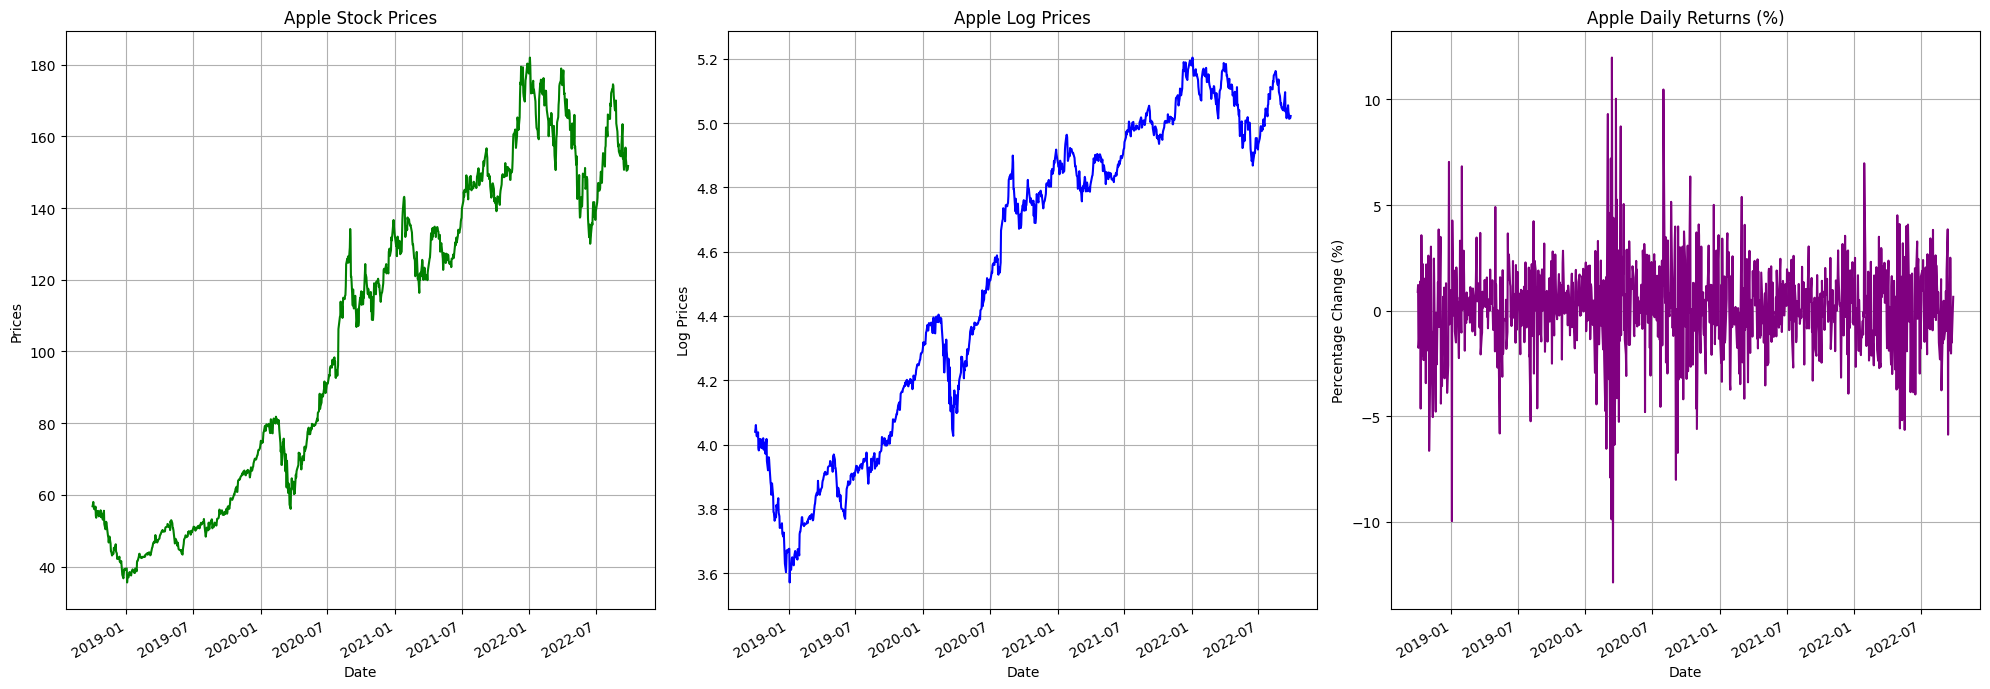

In [11]:
stock_price_plot(df, stock='Apple', split_ts=True, plot_type='line')


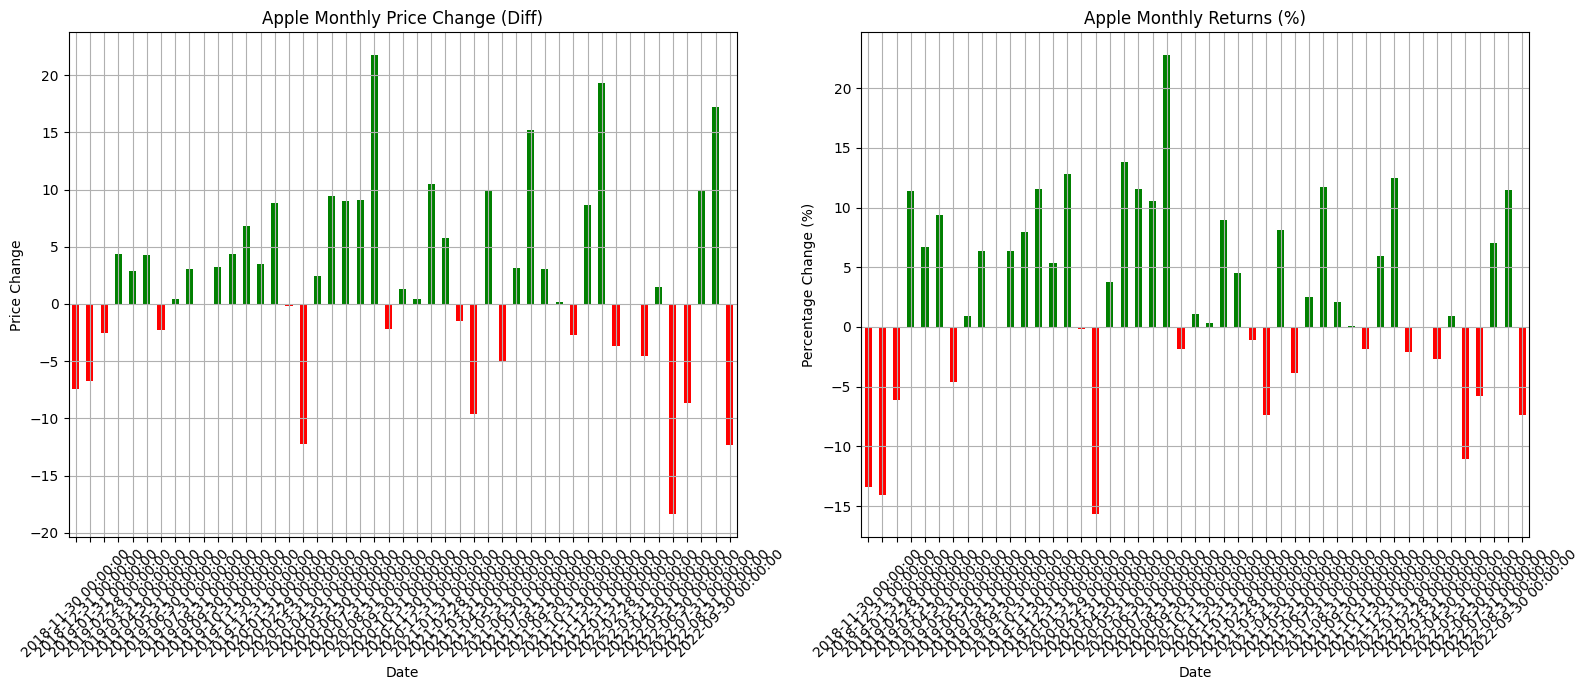

In [12]:
stock_price_plot(df, stock='Apple', split_ts=True, split_ratio=None,
                 resample='monthly', resample_method='mean',
                 plot_type='bar')

## Monthly plot

In [13]:
from posixpath import split
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

def mth_qtr_plot(df, stock, split_ts=None, split_ratio=None, resample=None, resample_method=None):
    """
    Function to generate monthly or quarterly seasonality plots.
    """
    # Validate resampling choice
    if resample not in ['monthly', 'quarterly']:
        raise ValueError("Invalid resample value. Choose 'monthly' or 'quarterly'.")

    # Train-test split if required
    if split_ts:
        train_df, test_df = split_ts_resample(df, resample, split_ratio=split_ratio, resample_method=resample_method)
    else: train_df = resample_data(df, resample, resample_method)

    #
    if resample == 'monthly':
        month_plot(train_df[stock], ylabel=stock)
    elif resample == 'quarterly':
        quarter_plot(train_df[stock], ylabel=stock)


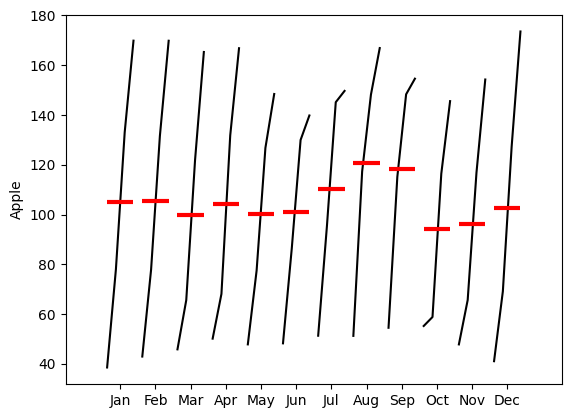

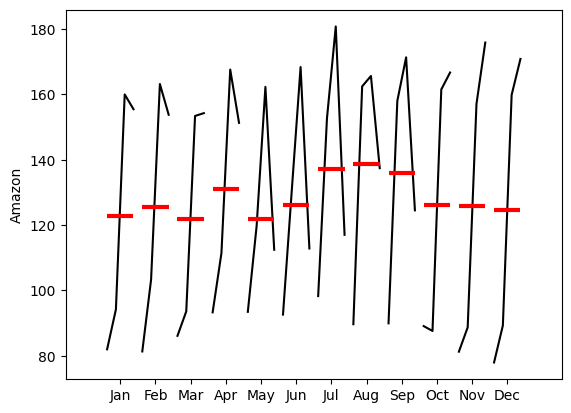

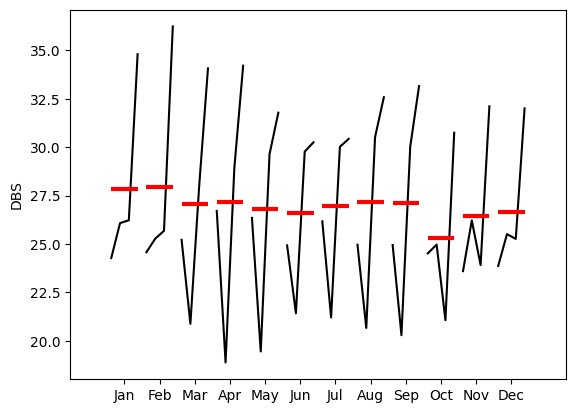

In [14]:
for col in df.columns:
    mth_qtr_plot(df, stock=col, split_ts=True, resample='monthly', resample_method='mean')

## Quarterly plot

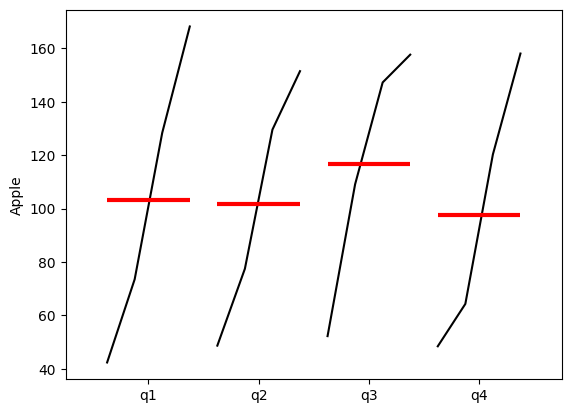

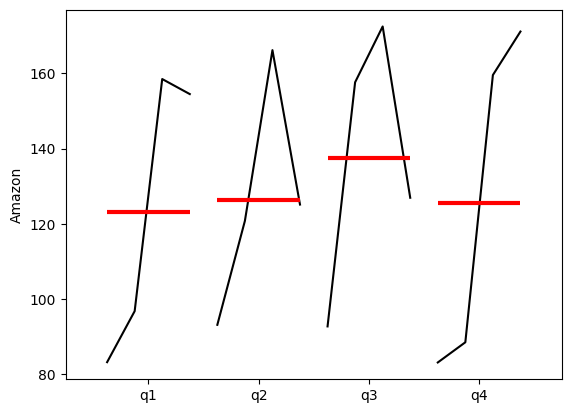

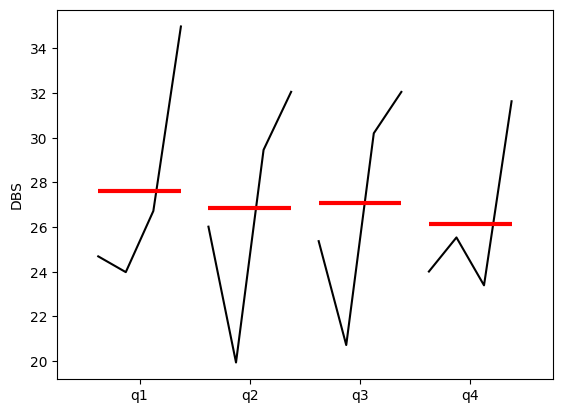

In [15]:
for col in df.columns:
    mth_qtr_plot(df, col, split_ts=True, resample='quarterly', resample_method='mean')

## Seasonal decomposition

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_decompose_subplot(df, stock, split_ts=None, split_ratio=None, resample=None, resample_method=None):

    # Ensure correct period selection
    valid_periods = {'daily': 30, 'weekly': 7, 'monthly': 12, 'quarterly': 4, 'yearly': 1}
    if resample not in valid_periods:
        raise ValueError("Invalid resample value. Choose 'daily', 'weekly', 'monthly', 'quarterly', or 'yearly'.")

    # Train/test split and resampling logic
    if split_ts and resample:
        train_df, test_df = split_ts_resample(df, resample, split_ratio=split_ratio, resample_method=resample_method)
    elif split_ts:
        train_df, test_df = time_series_split(df, split_ratio=split_ratio)
    elif resample and resample_method is not None:
        train_df = resample_data(df, resample, resample_method)
    else:
        train_df = df.copy()

    # Seasonal decomposition
    period = valid_periods[resample]
    add_model = seasonal_decompose(train_df[stock], model='additive', period=period)
    mul_model = seasonal_decompose(train_df[stock], model='multiplicative', period=period)

    # Subplot
    fig, axes = plt.subplots(4, 2, figsize=(16, 15))

    # Titles
    axes[0, 0].set_title("Additive Model")
    axes[0, 1].set_title("Multiplicative Model")

    # Plot each component (Observed, Trend, Seasonal, Residual)
    components = ["observed", "trend", "seasonal", "resid"] # attribute names
    component_labels = ["Observed", "Trend", "Seasonal", "Residual"] # legends

    for i, comp in enumerate(components):
        # Left (Additive)
        axes[i, 0].plot(getattr(add_model, comp), label=f"Additive {component_labels[i]}")
        axes[i, 0].legend()

        # Right (Multiplicative)
        axes[i, 1].plot(getattr(mul_model, comp), label=f"Multiplicative {component_labels[i]}")
        axes[i, 1].legend()

    plt.tight_layout()
    plt.show()


def seasonal_decomposition_results(df, model_type='add', split_ts=None, split_ratio=None, resample=None, resample_method='last'):

    # Ensure correct period selection
    valid_periods = {'daily': 30, 'weekly': 7, 'monthly': 12, 'quarterly': 4, 'yearly': 1}
    if resample not in valid_periods:
        raise ValueError("Invalid resample value. Choose 'daily', 'weekly', 'monthly', 'quarterly', or 'yearly'.")

    # Train/test split and resampling logic
    if split_ts and resample:
        train_df, test_df = split_ts_resample(df, resample, split_ratio=split_ratio, resample_method=resample_method)
    elif split_ts:
        train_df, test_df = time_series_split(df, split_ratio=split_ratio)
    elif resample:
        train_df = resample_data(df, resample, resample_method)
    else:
        train_df = df.copy()

    # Components
    components = ["observed", "trend", "seasonal", "resid"]

    # Create Dictionary to store sub dictionary: decomposed components
    decomposed_dfs = {comp: {} for comp in components}

    # Seasonal decomposition for each column
    period = valid_periods[resample]
    for col in train_df.columns:
        decomposition = seasonal_decompose(train_df[col], model=model_type, period=period)

        # Store each component in the main dictionary
        for component in components:
            decomposed_dfs[component][col] = getattr(decomposition, component)

    # Convert to DataFrames
    decomposed_dfs = {comp: pd.DataFrame(data) for comp, data in decomposed_dfs.items()}

    return decomposed_dfs

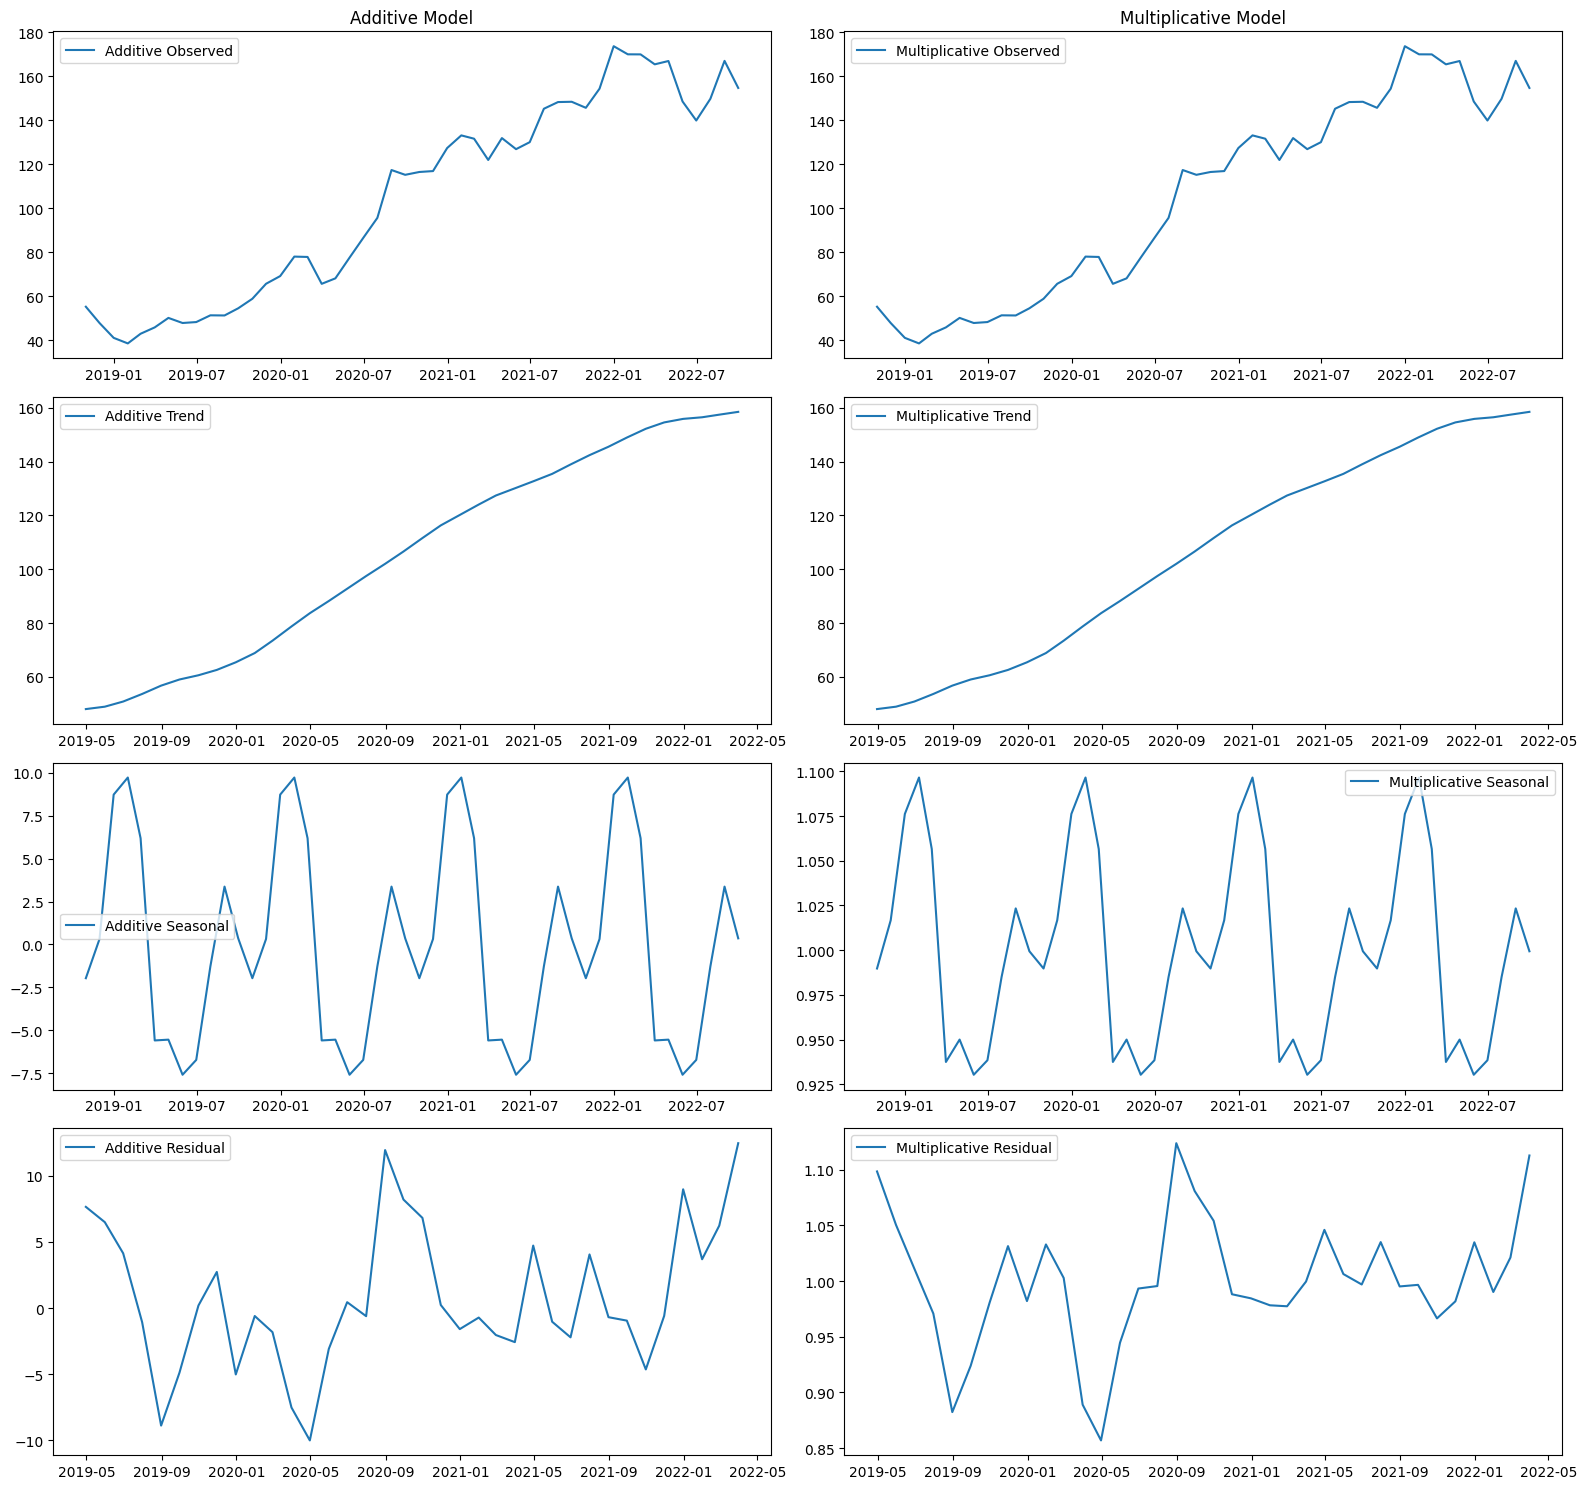

In [17]:
seasonal_decompose_subplot(df, 'Apple', split_ts=True,
                           resample='monthly', resample_method='mean')

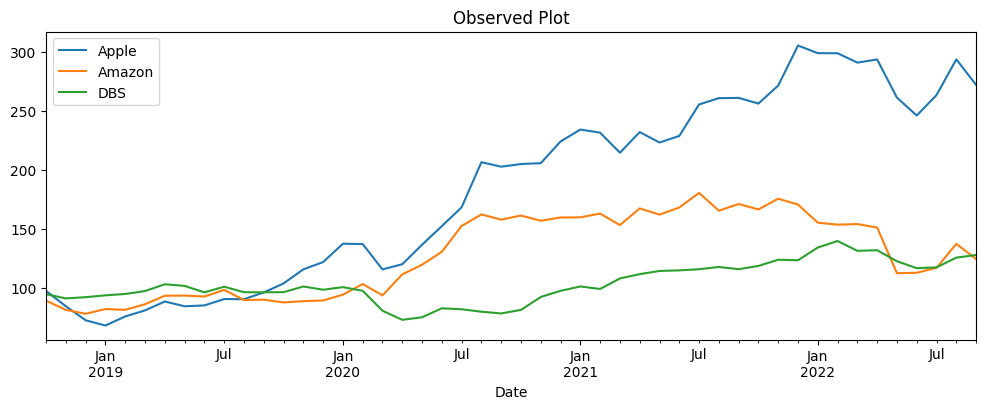

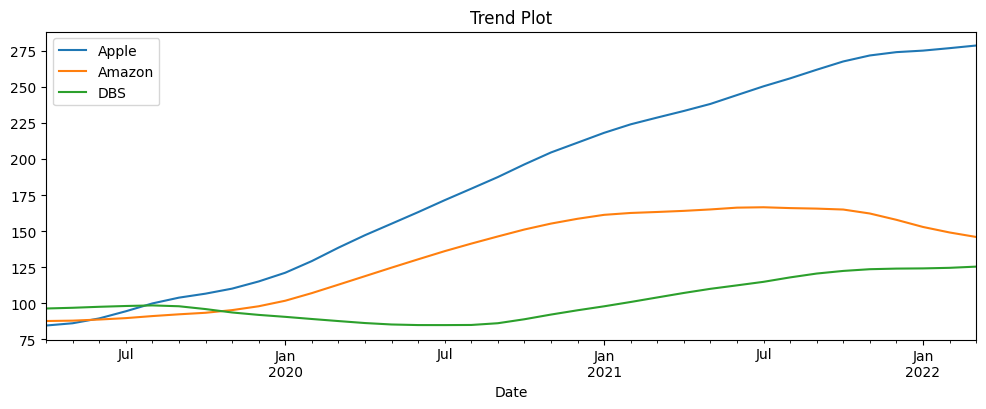

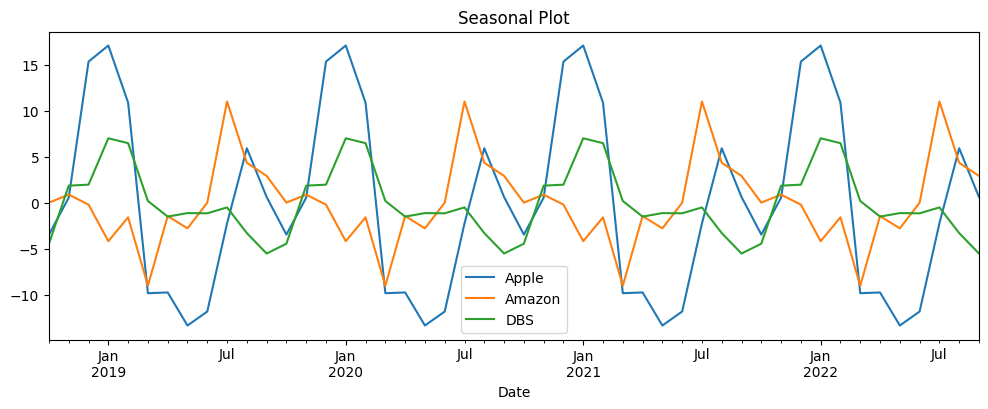

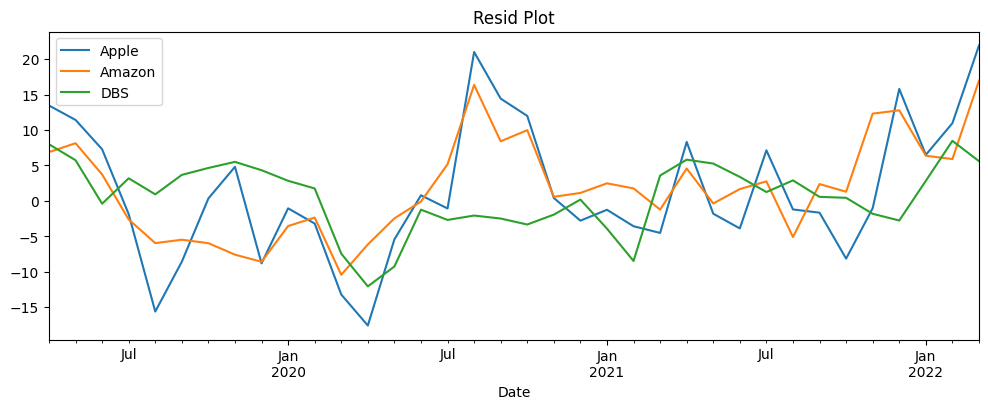

In [18]:
n_df = df.div(df.iloc[0]).mul(100)
season_decom_df = seasonal_decomposition_results(n_df, model_type='add',
                                                 split_ts=True, split_ratio=None,
                                                 resample='monthly', resample_method='mean')


components = ["observed", "trend", "seasonal", "resid"]
for i in components:
    season_decom_df[i].dropna().plot(figsize=(12, 4))
    plt.title(f'{i.capitalize()} Plot')
    plt.legend(loc='best')
    plt.show()

## ACF

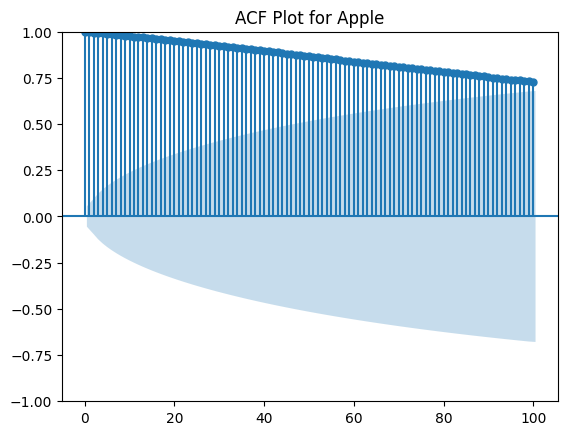

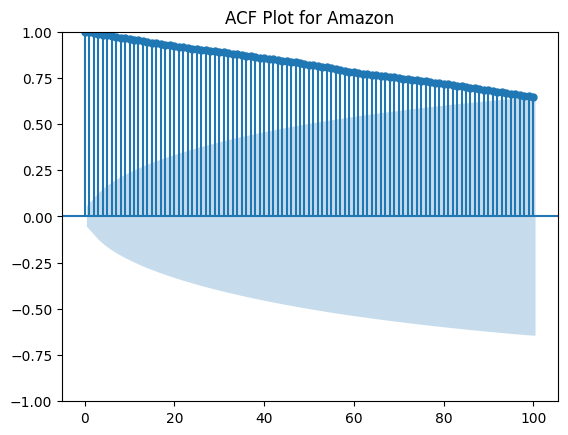

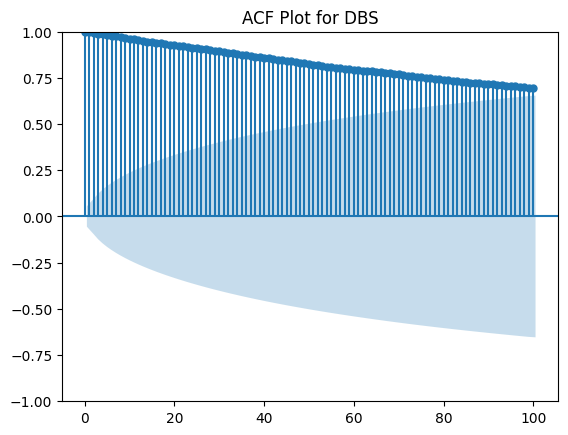

In [19]:
from statsmodels.graphics.tsaplots import plot_acf

for col in df.columns:
    plot_acf(df[col], lags=100)
    plt.title(f"ACF Plot for {col}")
    plt.show()

## PACF

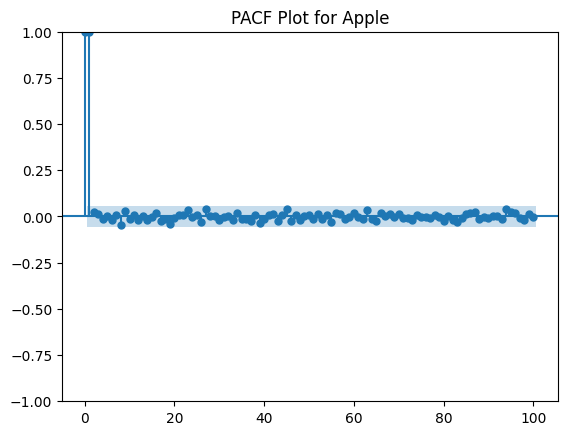

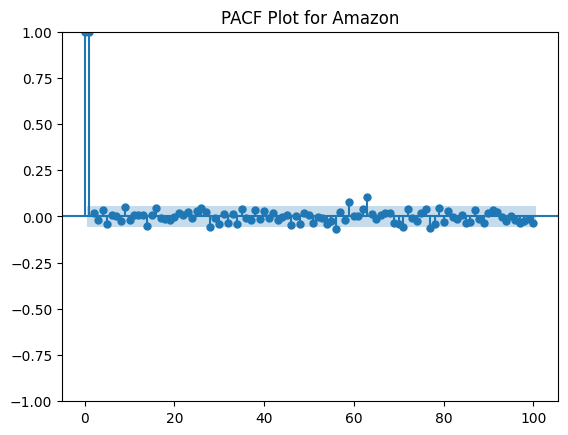

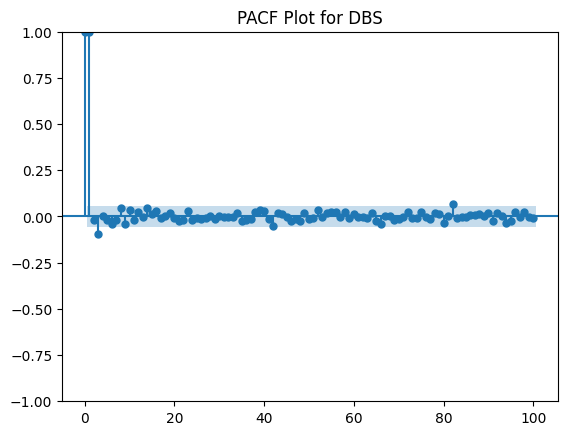

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf

for col in df.columns:
    plot_pacf(df[col], lags=100)
    plt.title(f"PACF Plot for {col}")
    plt.show()

## Pair plot

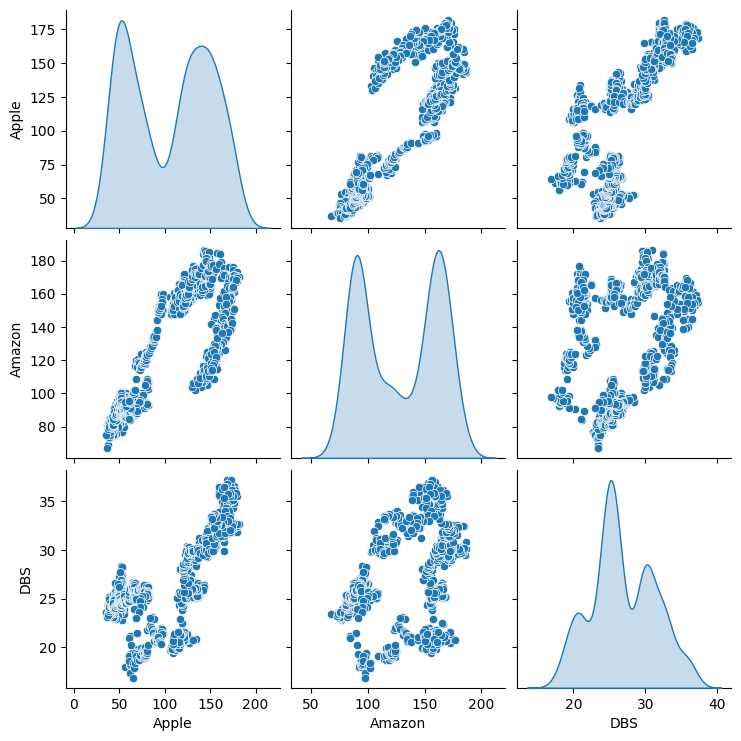

In [21]:
import seaborn as sns

sns.pairplot(train_df, diag_kind='kde')
plt.show()

# Features characteristic


## Price Correlation

In [22]:
import seaborn as sns

def heatmap_correlations(df, threshold=None, split_ts=None, split_ratio=None, resample=None, resample_method=None):
    '''
      Display heatmap of feature correlations.
    '''
    # Train/test split and resampling logic
    if split_ts and resample:
        train_df, test_df = split_ts_resample(df, resample, split_ratio=split_ratio, resample_method=resample_method)
    elif split_ts:
        train_df, test_df = time_series_split(df, split_ratio=split_ratio)
    elif resample and resample_method is not None:
        train_df = resample_data(df, resample, resample_method)
    else:
        train_df = df.copy()

    plt.figure()
    mask = np.triu(np.ones_like(train_df, dtype=bool)) | df.isnull() # Create a mask for the upper triangle to be blank
    sns.heatmap(train_df, annot=True, cmap='coolwarm', mask=mask, fmt=".2f")
    plt.title(f"Feature Correlation Heatmap (Threshold ≥ {threshold})" if threshold else "Feature Correlation Heatmap")
    plt.show()


def plot_scatter(df, stock1, stock2, split=False, period=None):
    '''
      Plot scatter plot of two stocks.
    '''
    if split:
        train_df, test_df = time_series_split(df)
    else: train_df = df.copy()

    valid_period = {'monthly': 'ME', 'quarterly': 'QE', 'yearly': 'YE'}
    if period is not None:
        train_df = train_df.resample(valid_period[period]).mean()

    sns.regplot(x=train_df[stock1], y=train_df[stock2], line_kws={'color':'red'})
    plt.title(f"{stock1} vs {stock2} Scatter Plot")
    plt.xlabel(stock1)
    plt.ylabel(stock2)
    plt.show()


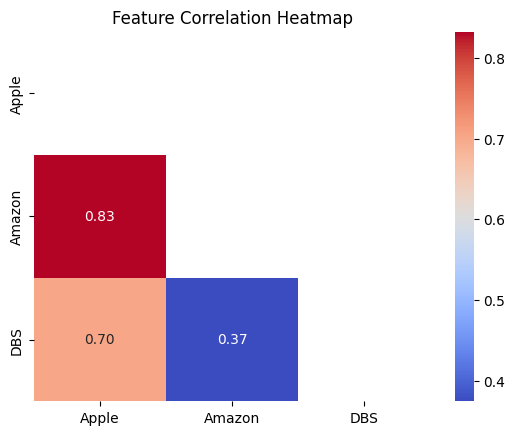

In [23]:
heatmap_correlations(train_df.corr())

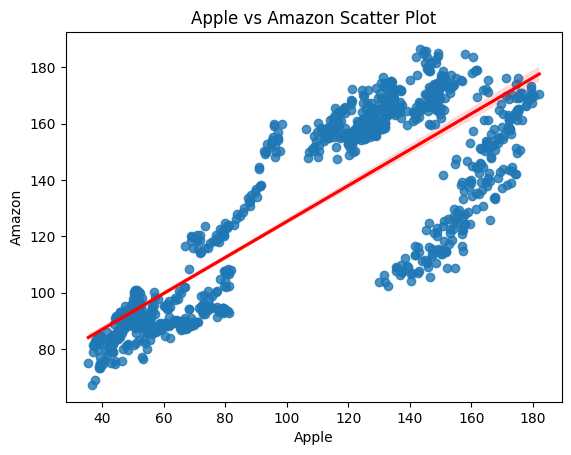

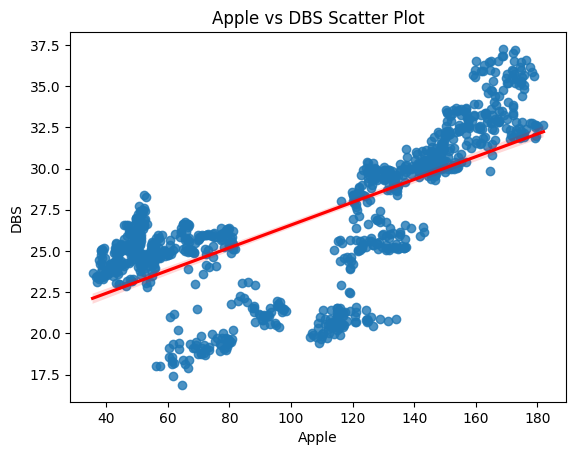

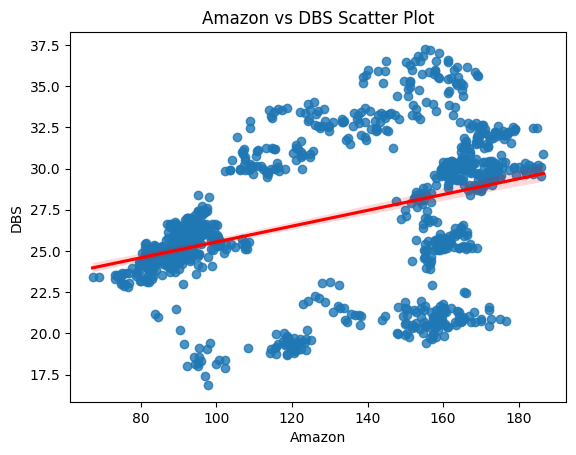

In [24]:
from itertools import combinations
pairs = list(combinations(df.columns, 2))

for pair in pairs:
    plot_scatter(train_df, pair[0], pair[1])

## Stationarity

In [25]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

def check_stationarity(df, alpha=0.05, output=False, split=False):
    stationary_col = []
    non_stationary_col = []
    if split:
        train_df, test_df = time_series_split(df)
    else: train_df = df.copy()

    for column in df.columns:
        result = adfuller(train_df[column].dropna())
        if result[1] < alpha:
            stationary_col.append(column)
        else:
            non_stationary_col.append(column)

    print(f"Stationary Columns: {stationary_col}")
    print(f"Non-Stationary Columns: {non_stationary_col}")

    if output:
        return stationary_col, non_stationary_col


In [26]:
check_stationarity(df, output=False)

Stationary Columns: []
Non-Stationary Columns: ['Apple', 'Amazon', 'DBS']


In [27]:
check_stationarity(df.diff(1).dropna(), output=False)

Stationary Columns: ['Apple', 'Amazon', 'DBS']
Non-Stationary Columns: []


## Cointergraiton

In [28]:
def check_cointegration(df, stock1, stock2, alpha=0.05, split=False):
    '''
        Check coinegration between two stocks.
    '''
    # Time series split
    if split:
        train_df, test_df = time_series_split(df)
    else: train_df = df.copy()

    # Get price series from df
    stock1_price = train_df[stock1]
    stock2_price = train_df[stock2]

    # Ensure stocks time series are align
    common_index = stock1_price.index.intersection(stock2_price.index)
    x = stock1_price.loc[common_index] # independent
    y = stock2_price.loc[common_index] # dependent

    # OLS regression to find hedge ratio
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    hedge_ratio = model.params.iloc[-1]

    # Compute spread (residual)
    residual = y - hedge_ratio * x.iloc[:, 1]

    # ADF test for stationarity
    adf_test = adfuller(residual)
    p_value = adf_test[1]
    cointegration = p_value < alpha

    # Print results
    print(f"{stock1} vs {stock2}")
    # print(f"ADF Statistic: {adf_test[0]:.4f}")
    # print(f"p-value: {p_value:.4f}")
    # print(f"Hedge Ratio: {hedge_ratio:.4f}")
    print(f"Cointegration: {'Yes, Linear regression is valid' if cointegration else 'No, use caution with linear model.'}")
    print("")

In [29]:
for pair in pairs:
    check_cointegration(train_df, pair[0], pair[1])

Apple vs Amazon
Cointegration: No, use caution with linear model.

Apple vs DBS
Cointegration: No, use caution with linear model.

Amazon vs DBS
Cointegration: No, use caution with linear model.



# Stock prediction with Linear Model

## Linear model function library

In [30]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score


def time_series_split(df, split_ratio=0.8, idx=False):
    split_idx = int(len(df) * split_ratio)

    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]

    if idx:
        return train_df, test_df, split_idx
    return train_df, test_df


def residuals_plot(y_test, y_hat, predictor, response):
    """
        Plot residual diagnostics
    """
    residuals = y_test - y_hat
    plt.figure(figsize=(8,5))
    plt.scatter(y_hat, residuals, alpha=0.5, color='blue')
    plt.axhline(0, color='red', linestyle='dashed')
    plt.xlabel(f"Fitted Values (Predicted): {response}")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Fitted Values")
    plt.show()


def reg_plot(model, predictor):
    '''
        Regression plot
    '''
    fig = plt.figure(figsize=(12, 8))
    fig = sm.graphics.plot_regress_exog(model, predictor, fig=fig)
    plt.show()


def time_series_plot(train_df, test_df, predictor, response, y_hat, perf_metric):
    """
    Plots actual vs predicted stock prices.
    """
    y_test = test_df[response]
    plt.figure(figsize=(12, 6))
    # Actual price
    plt.plot(train_df.index, train_df[response], label=f"Train Data: {response}", color="blue")
    plt.plot(test_df.index, test_df[response], label=f"Test Data: {response}", color="green")
    # Predicted price
    plt.plot(test_df.index, y_hat, label=f"Predicted {response}", color="red", linestyle="dashed")
    # Start of test
    plt.axvline(x=test_df.index[0], color="black", linestyle="dashed", label="Train-Test Split")
    # Add performance metrics
    if perf_metric:
        metrics = performance_metrics(y_test, y_hat)
        metrics_text = f"MSE: {metrics['MSE']:.3f}\nRMSE: {metrics['RMSE']:.3f}\nMAPE: {metrics['MAPE']:.2%}\nR²: {metrics['R²']:.3f}"
        plt.text(
            0.02, 0.8, metrics_text, transform=plt.gca().transAxes, fontsize=12,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="black")
        )

    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title(f"{response} Price Prediction Using {predictor}")
    plt.legend(loc='lower right')
    plt.show()



def performance_metrics(y_test, y_hat):
    """
    Computes and returns model performance metrics.
    """
    return {
        "MSE": mean_squared_error(y_test, y_hat),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_hat)),
        "MAPE": mean_absolute_percentage_error(y_test, y_hat),
        "R²": r2_score(y_test, y_hat)
    }

def single_variable(train_df, test_df, predictor, response):
    '''
        Single variable linear regression(X, y)
    '''
    # Ensure columns exist
    if predictor not in train_df.columns or response not in train_df.columns:
        raise ValueError(f"Columns '{predictor}' or '{response}' not found in DataFrame.")

    # Drop NaN values
    train_df = train_df.dropna(subset=[predictor, response])
    test_df = test_df.dropna(subset=[predictor, response])

    # Train model
    train_x, train_y = sm.add_constant(train_df[predictor]), train_df[response]
    model = sm.OLS(train_y, train_x).fit()

    # Test model
    test_x, test_y = sm.add_constant(test_df[predictor]), test_df[response]
    y_hat = model.predict(test_x)

    return model, test_y, y_hat


def multi_variable(train_df, test_df, predictors, response):
      '''
        Multi variable linear regression(X, y)
      '''
      # Ensure columns exist
      if response not in train_df.columns or not all(col in train_df.columns for col in predictors):
          raise ValueError(f"Columns '{predictors}' or '{response}' not found in DataFrame.")

      # Drop NaN values (convert tuple to list for compatibility)
      train_df = train_df.dropna(subset=list(predictors) + [response])
      test_df = test_df.dropna(subset=list(predictors) + [response])

      # Define and fit the model
      formula = f'{response} ~ {" + ".join(predictors)}'
      model = ols(formula=formula, data=train_df).fit()

      # Make predictions
      y_test = test_df[response]
      y_hat = model.predict(test_df[predictors])

      return model, y_test, y_hat


def linear_model(train_df, test_df, predictors, response, model_type='single', output=False, show_summary=False, show_metric=False, plot_ts=False, plot_residual=False, plot_reg=False):
    """
        omg omg omg
    """
    if model_type == 'single':
        model, y_test, y_hat = single_variable(train_df, test_df, predictors, response)

    if model_type == 'multi':
        model, y_test, y_hat = multi_variable(train_df, test_df, predictors, response)

    # Print summary if requested
    if show_summary:
        print(model.summary())

    # Compute and display performance metrics
    metrics = performance_metrics(y_test, y_hat)
    if show_metric:
        return metrics

    # Plot actual vs predicted
    if plot_ts:
        time_series_plot(train_df, test_df, predictors, response, y_hat, perf_metric=True)

    # Plot residuals
    if plot_residual:
        residuals_plot(y_test, y_hat, predictors, response)

    # Plot regression plot
    if plot_reg and model_type == 'single':
        reg_plot(model, predictors)
    elif  plot_reg and model_type == 'multi':
        print('Regression plot not available for multi-variable')

    if output:
        return model, y_test, y_hat


## Single Variable linear model

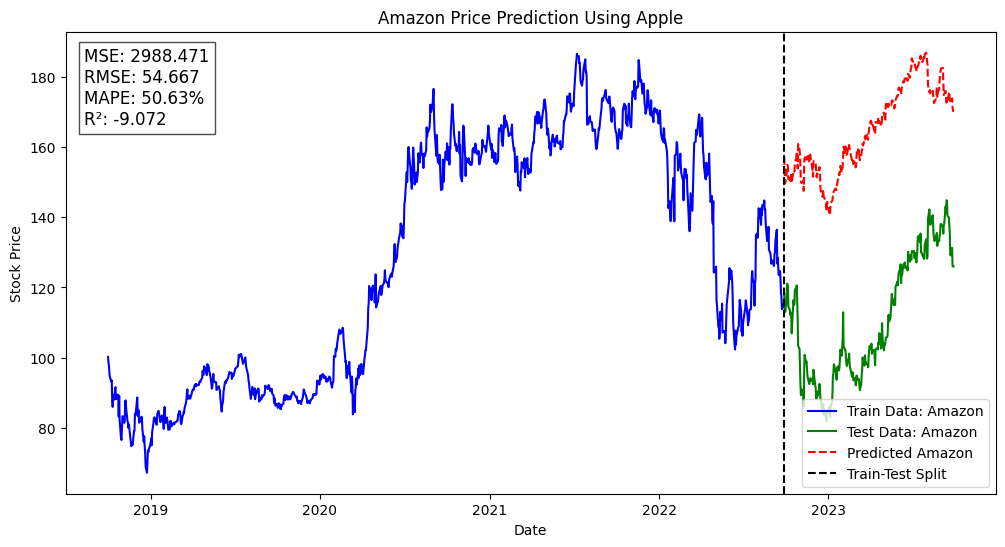

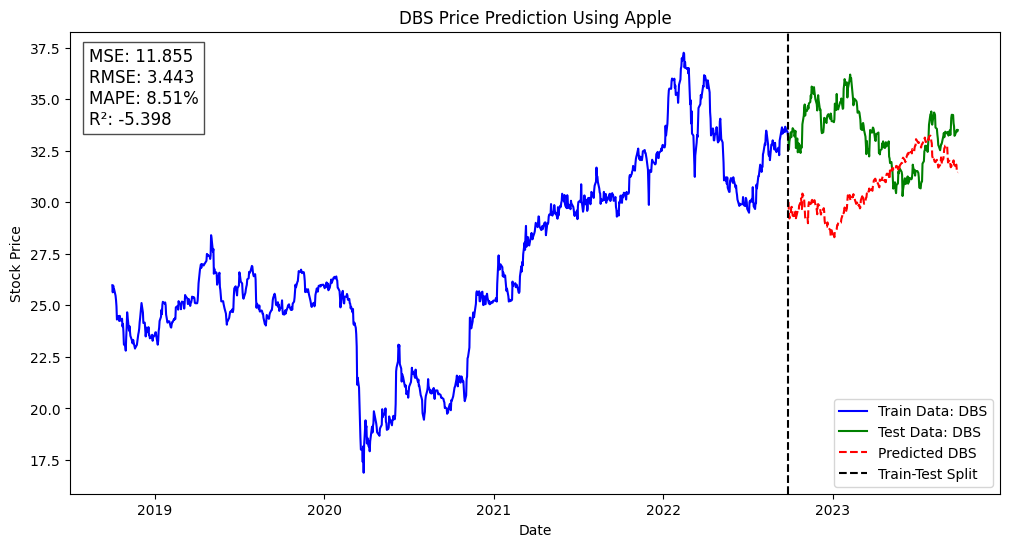

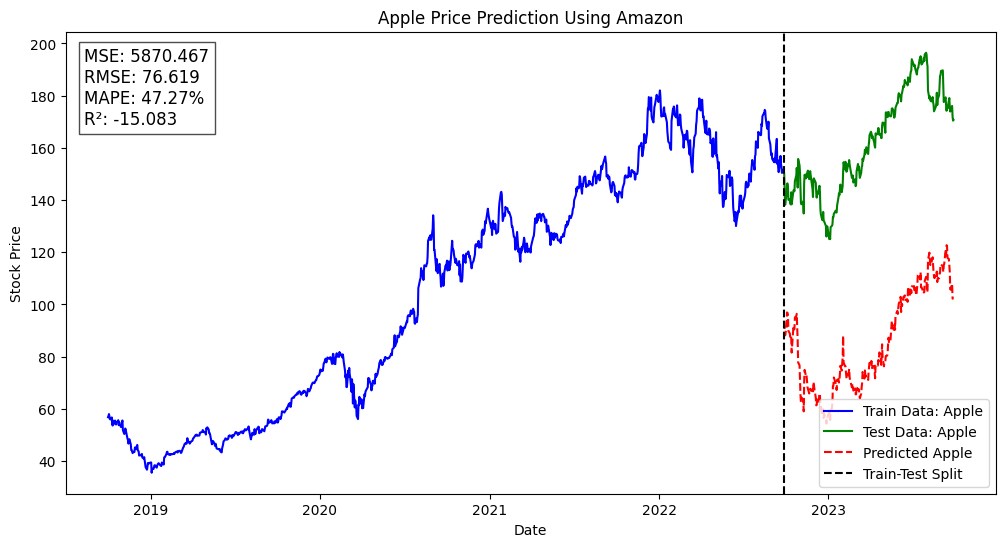

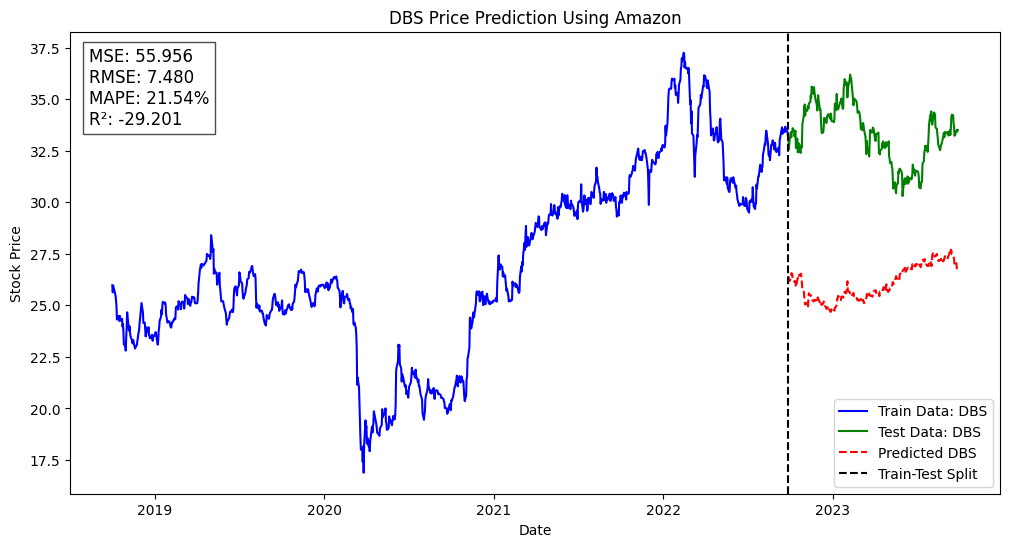

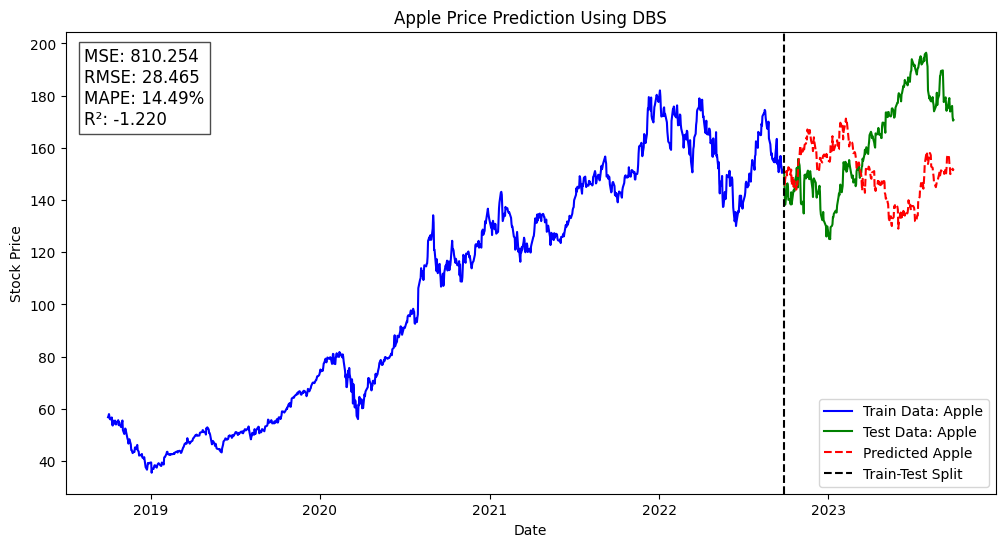

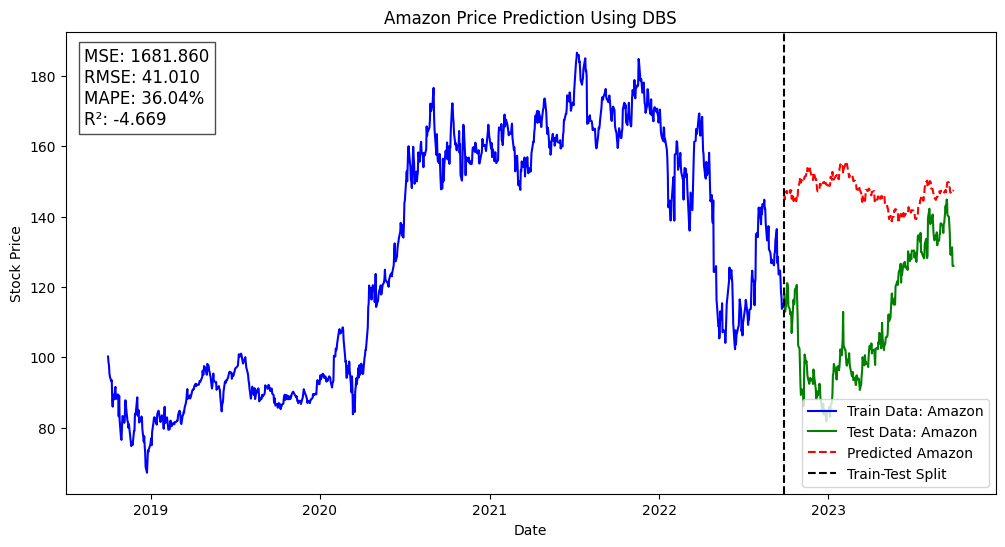

In [31]:
from itertools import product
pairs = list(product([x for x in df.columns], repeat=2))

for predictor, response in pairs:
    if predictor != response:
        linear_model(train_df, test_df, predictor, response, model_type='single',
                    output=True, show_summary=False,
                    plot_ts=True, plot_residual=False, plot_reg=False)

## Multi-variable linear model

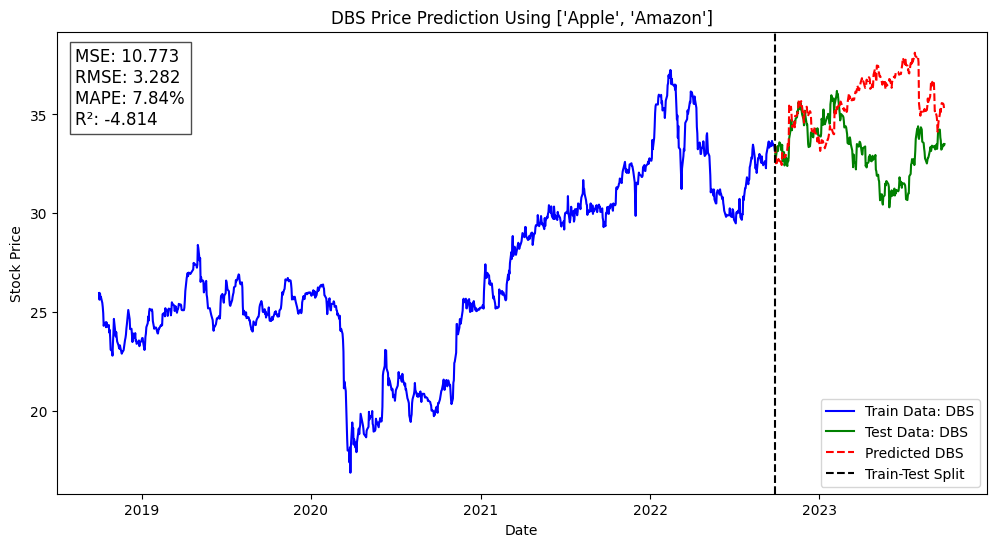

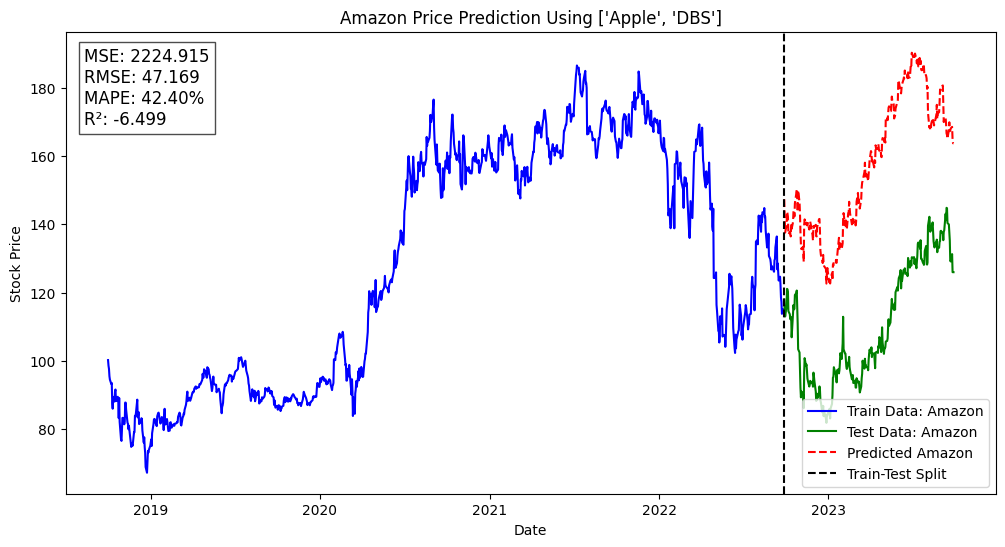

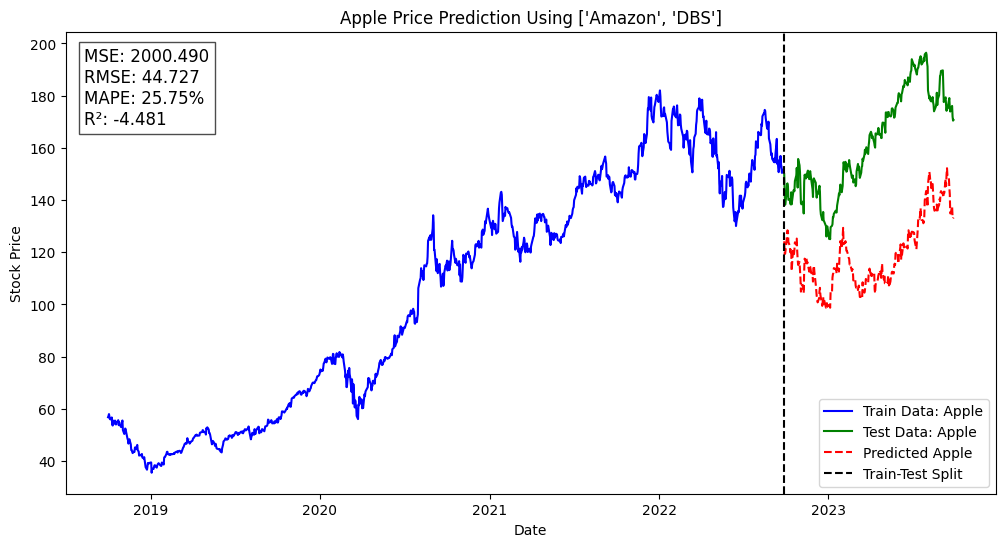

In [32]:
from itertools import combinations
triplets = list(combinations(df.columns, 2))

for predictors in triplets:
    response = set(df.columns) - set(predictors)  # Find the column not in the pair
    linear_model(train_df, test_df, list(predictors), list(response)[0], model_type='multi',
                 output=True, show_summary=False,
                 plot_ts=True, plot_residual=False, plot_reg=False)


## Experiment: Stock Price with Features

In [33]:
data = df[['Apple']].copy()

# Create lag features
for lag in range(1, 6):
    data[f'lag_{lag}'] = data['Apple'].shift(lag)

# Create rolling moving averages
data['SMA_5'] = data['Apple'].rolling(window=5).mean()
data['SMA_10'] = data['Apple'].rolling(window=10).mean()

# Calculate returns & volatility
data['Return'] = data['Apple'].pct_change()
data['Volatility'] = data['Return'].rolling(window=10).std()

# Drop NaNs (since rolling functions create NaN values)
data.dropna(inplace=True)

X = data.drop('Apple', axis=1).columns.to_list()
y = 'Apple'

aapl_train, aapl_test = time_series_split(data)


                            OLS Regression Results                            
Dep. Variable:                  Apple   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.252e+29
Date:                Sun, 09 Feb 2025   Prob (F-statistic):               0.00
Time:                        05:35:06   Log-Likelihood:                 26462.
No. Observations:                 997   AIC:                        -5.290e+04
Df Residuals:                     987   BIC:                        -5.285e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.464e-13   7.68e-14      1.908      0.0

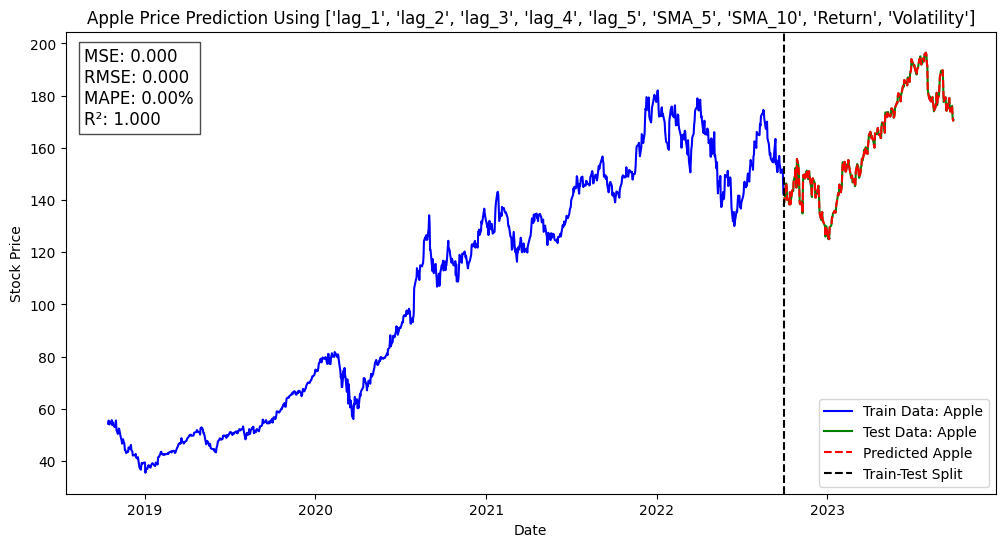

In [34]:
linear_model(aapl_train, aapl_test, X, y, model_type='multi',
             output=False, show_summary=True,
             plot_ts=True, plot_residual=False, plot_reg=False)

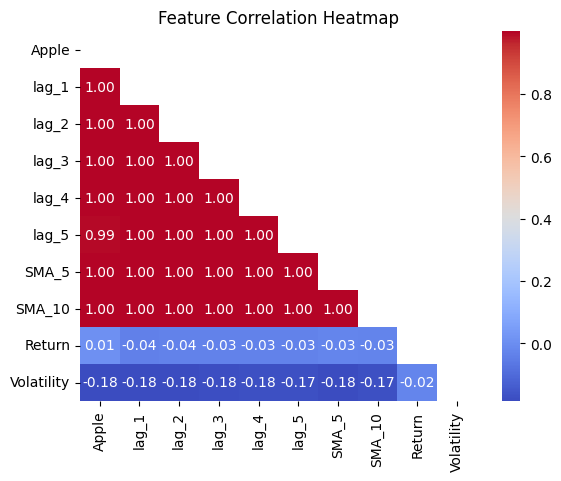

In [35]:
heatmap_correlations(data.corr())

# Stock prediction with Holt Winters

## HW function library

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from itertools import product


def time_series_split(df, split_ratio=0.8, idx=False):
    split_idx = int(len(df) * split_ratio)

    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]

    if idx:
        return train_df, test_df, split_idx
    return train_df, test_df


def performance_metrics(y_test, y_hat):
    """Computes and returns model performance metrics."""
    return {
        "MSE": mean_squared_error(y_test, y_hat),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_hat)),
        "MAPE": mean_absolute_percentage_error(y_test, y_hat),
        "R²": r2_score(y_test, y_hat)
    }


def time_series_HW_plot(results, stock, train_idx, test_idx):
    """Plots actual vs predicted stock prices with performance metrics."""

    y_test = results.loc[test_idx, stock]

    # Extract prediction columns
    model_names = [col for col in results.columns if "_" in col]  # Only keep model predictions

    plt.figure(figsize=(12, 6))

    # Plot actual prices
    # plt.plot(train_idx, results.loc[train_idx, stock], label="Train Data", color="blue")
    # plt.plot(test_idx, results.loc[test_idx, stock], label="Test Data", color="green")
    plt.plot(results.index, results[stock], label="Actual Price", color="blue")

    # Compute performance metrics
    perf_metrics = {}

    # Plot predicted values
    for model_name in model_names:
        plt.plot(test_idx, results.loc[test_idx, model_name], label=f"{model_name}", linestyle="dashed")
        perf_metrics[f'{model_name}'] = None
        perf_metrics[f'{model_name}'] = performance_metrics(y_test, results.loc[test_idx, model_name])

    # Train-Test Split marker
    plt.axvline(x=test_df.index[0], color="black", linestyle="dashed", label="Train-Test Split")

    # Display performance metrics
    metrics_text = pd.DataFrame(perf_metrics)

    plt.text(
        0.02, 0.78, metrics_text.T, transform=plt.gca().transAxes, fontsize=10,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="black")
    )

    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title(f"Holt-Winters Price Prediction: {stock}")
    plt.legend(loc='lower right')
    plt.show()


def Holt_Winters_forecast(df, stock, period='monthly', plot_ts=False, output=False):
    """Runs Holt-Winters forecasting and returns predictions."""

    # Resampling Frequency Mapping
    valid_period = {'monthly': 'ME', 'quarterly': 'QE', 'yearly': 'A'}
    seasonal_mapping = {'monthly': 12, 'quarterly': 4, 'yearly': 1}

    if period not in valid_period:
        raise ValueError("Invalid period. Choose from 'monthly', 'quarterly', or 'yearly'.")

    # Resample data
    df = df[[stock]].copy()
    resample_df = df.resample(valid_period[period]).ffill()

    # Create new dataframe to sort predicted results
    predictions_df = resample_df.copy()

    # Time series split
    train_df, test_df = time_series_split(resample_df)

    # Find the permutation of model type
    model_type = ['add', 'mul']
    pairs = list(product(model_type, repeat=2))

    # Fit & forecast model
    for trend_type, seasonal_type in pairs:
        try:
            model = ExponentialSmoothing(
                                          train_df[stock],
                                          trend=trend_type,
                                          seasonal=seasonal_type,
                                          seasonal_periods=seasonal_mapping[period]
                                        ).fit()

            steps = len(test_df)
            test_pred = model.forecast(steps=steps)
            predictions_df[f'{trend_type}_{seasonal_type}'] = None
            predictions_df.loc[train_df.index, f'{trend_type}_{seasonal_type}'] = model.fittedvalues
            predictions_df.loc[test_df.index, f'{trend_type}_{seasonal_type}'] = test_pred

        except Exception as e:
            print(f"Error with model {trend_type}_{seasonal_type}: {e}")

    predictions_df.dropna(axis=1, how='all', inplace=True)

    if plot_ts:
        time_series_HW_plot(predictions_df, stock, train_df.index, test_df.index)

    if output:
        return predictions_df, train_df, test_df

## HW prediction

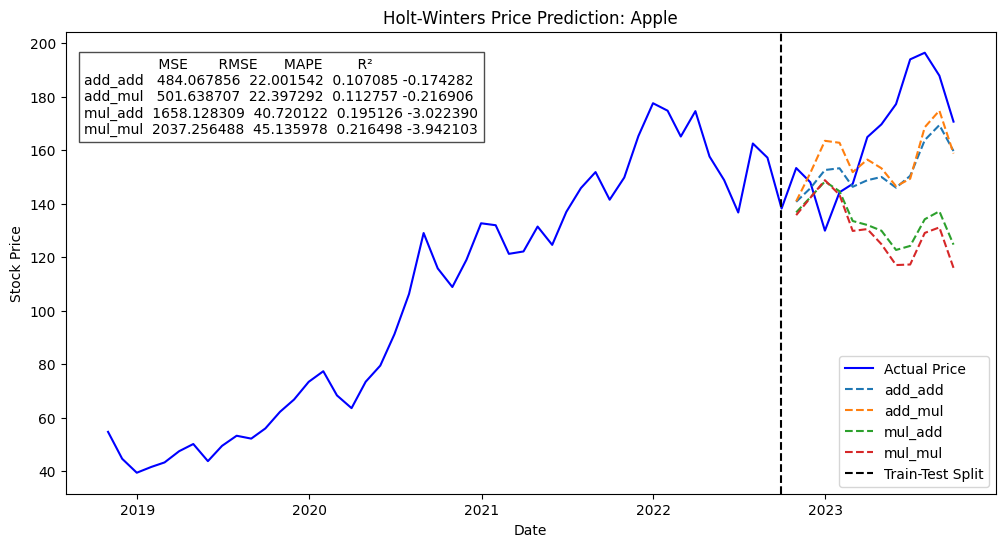

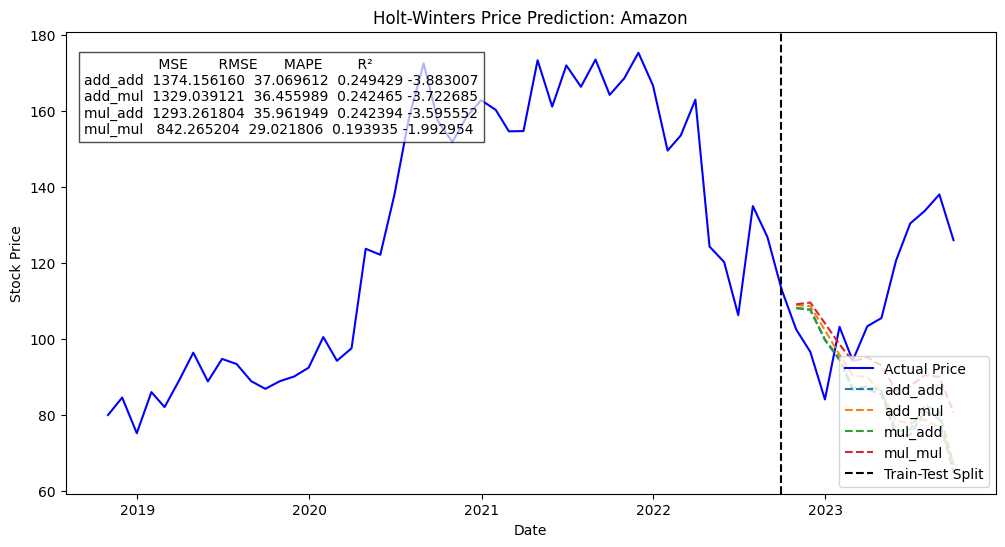

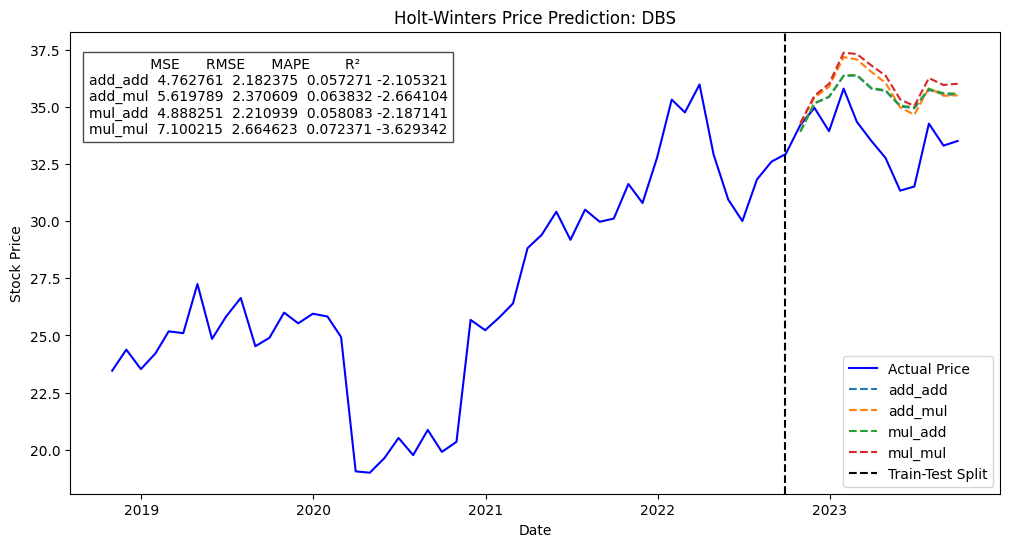

In [37]:
for col in df.columns:
    Holt_Winters_forecast(df, col, period='monthly', plot_ts=True, output=False)

# Stock prediction with ARIMA

## ARIMA function library

In [12]:
from pmdarima.arima import auto_arima
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")


def time_series_split(df, split_ratio=None):

    if split_ratio is None:
        split_ratio = 0.8
    split_idx = int(len(df) * split_ratio)

    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]

    return train_df, test_df


def time_series_arima_plot(df, stock, y_hat, conf_interval, order):
    """
        Plots actual vs predicted stock prices.
    """
    train_df, test_df = time_series_split(df)
    y_test = test_df[stock]
    plt.figure(figsize=(12, 6))

    # Actual price
    plt.plot(train_df.index, train_df[stock], label=f"Train Data: {stock}", color="blue")
    plt.plot(test_df.index, test_df[stock], label=f"Test Data: {stock}", color="green")

    # Predicted price
    plt.plot(test_df.index, y_hat, label=f"Predicted {stock}", color="red", linestyle="dashed")
    plt.fill_between(test_df.index, conf_interval.iloc[:, 0], conf_interval.iloc[:, 1],
                     color="red", alpha=0.1, label="Confidence Interval")

     # Train-Test Split marker
    plt.axvline(x=test_df.index[0], color="black", linestyle="dashed", label="Train-Test Split")

    # Add performance metrics
    metrics = performance_metrics(y_test, y_hat)
    metrics_text = f"MSE: {metrics['MSE']:.3f}\nRMSE: {metrics['RMSE']:.3f}\nMAPE: {metrics['MAPE']:.2%}\nR²: {metrics['R²']:.3f}"
    plt.text(
        0.02, 0.8, metrics_text, transform=plt.gca().transAxes, fontsize=12,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="black")
    )
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title(f"ARIMA Price Prediction: {stock}, Order: {order}")
    plt.legend(loc='lower right')
    plt.show()


def performance_metrics(y_test, y_hat):
    """
        Computes and returns model performance metrics.
    """
    return {
        "MSE": mean_squared_error(y_test, y_hat),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_hat)),
        "MAPE": mean_absolute_percentage_error(y_test, y_hat),
        "R²": r2_score(y_test, y_hat)
    }


def check_stationarity(series, alpha=0.05):
    """
        Perform ADF test to check stationarity.
    """
    result = adfuller(series.dropna())
    return result[1] < alpha  # p-value < 0.05 → Stationary


def ARIMA_hyperparameter(df):
    p = range(0, 5)
    d = range(1, 2)  # Typically 1 is sufficient
    q = range(0, 5)

    pdq_combinations = list(product(p, d, q))

    best_aic = float("inf")
    best_params = None

    for param in pdq_combinations:
        try:
            model = ARIMA(df, order=param).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_params = param
        except:
            continue

    return best_params

def auto_arima_tuning(df):
  # Find optimal ARIMA order
  model_autoARIMA = auto_arima(df,
                                start_p=0, start_q=0,
                                test='adf',  # Determine 'd' using ADF test
                                max_p=3, max_q=3,
                                m=1,         # Frequency
                                d=None,      # Let model decide
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)
  return model_autoARIMA.order


def ARIMA_forecast(df, stock, plot_ts=False, summary=False, output=False, tuning=None):

    # Train Test split
    df = df[[stock]].copy() # return df
    train_df, test_df = time_series_split(df)

    # Handle missing values before modeling
    train_df = train_df.interpolate().dropna(subset=[stock])
    test_df = test_df.interpolate().dropna(subset=[stock])

    # Find best ARIMA parameters
    if tuning is None or tuning=='hyperparameter':
        best_para = ARIMA_hyperparameter(train_df[stock])
    elif tuning == 'auto_arima':
        best_para = auto_arima_tuning(train_df[stock])

    if best_para is None:
        raise ValueError(f"Could not find suitable ARIMA parameters for {stock}")

    # Train ARIMA model
    model = ARIMA(train_df[stock], order=best_para).fit()

    # Generate in-sample predictions
    start = train_df.index[0]
    end = train_df.index[-1]
    # train_pred = model.predict(start=start, end=end) # predicted_mean
    train_pred = model.get_prediction(start=start, end=end).predicted_mean

    # Generate predictions
    steps = len(test_df)
    test_pred = model.forecast(steps=steps) # predicted_mean
    # test_pred = model.get_forecast(steps=steps).predicted_mean

    # Prediction confidence interval
    conf_int = model.get_forecast(steps=steps).conf_int()

    # Combine predictions into df
    temp_df = df.copy() # create new df
    temp_df['Predictions'] = None  # Initialize new column
    temp_df.loc[train_df.index, 'Predictions'] = train_pred
    temp_df.loc[test_df.index, 'Predictions'] = test_pred

    if plot_ts:
        time_series_arima_plot(temp_df, stock, test_pred, conf_int, best_para)

    if summary:
          print(model.summary())

    if output:
        return model, temp_df,

## ARIMA prediction

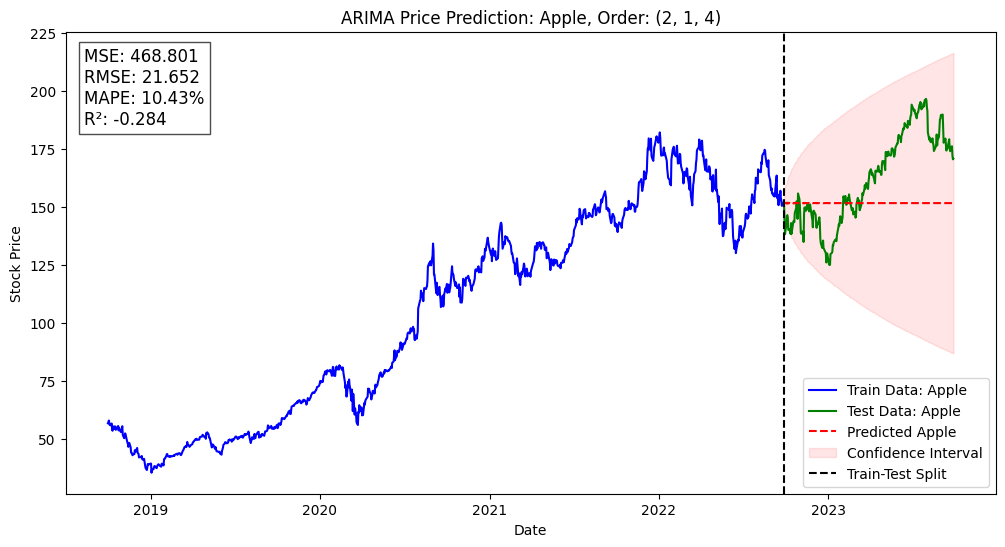

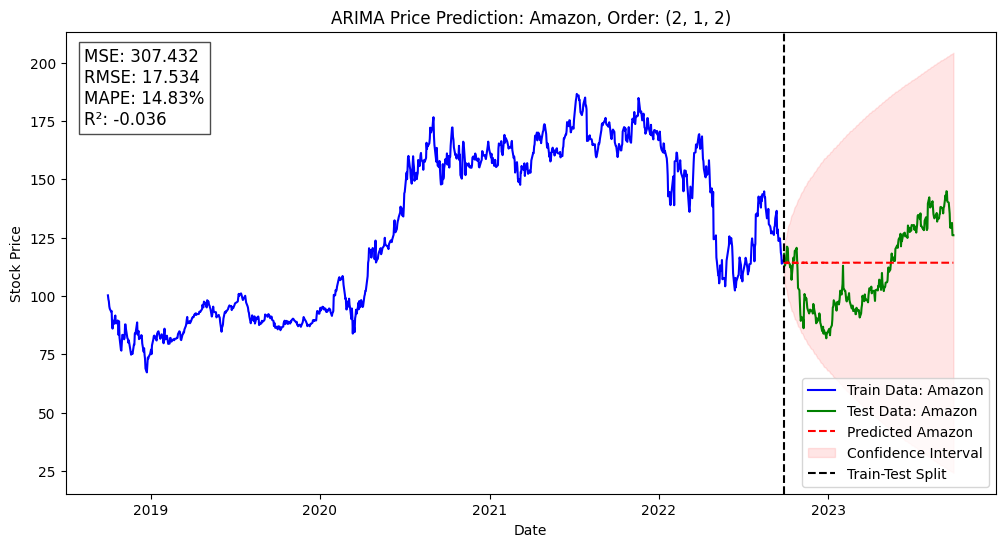

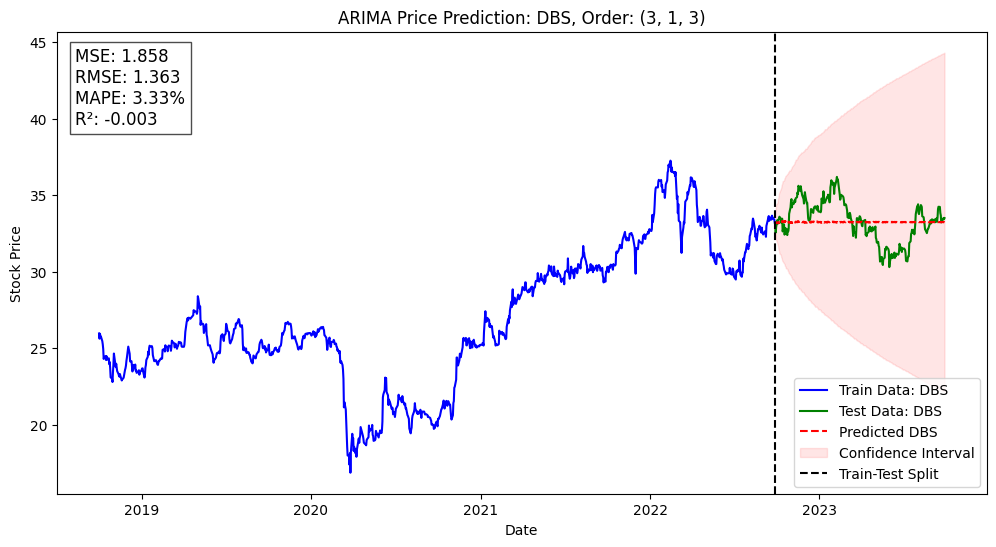

In [13]:
for cols in df.columns:
    ARIMA_forecast(df, cols, plot_ts=True, summary=False, output=False, tuning='hyperparameter')

## Auto ARIMA

In [42]:
# !pip install pmdarima

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4516.291, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4513.326, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4513.189, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4516.003, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4514.972, Time=0.97 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4515.040, Time=0.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4516.969, Time=1.00 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4513.178, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4515.030, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4515.075, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4513.289, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4517.027, Time=1.81 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.204 seconds


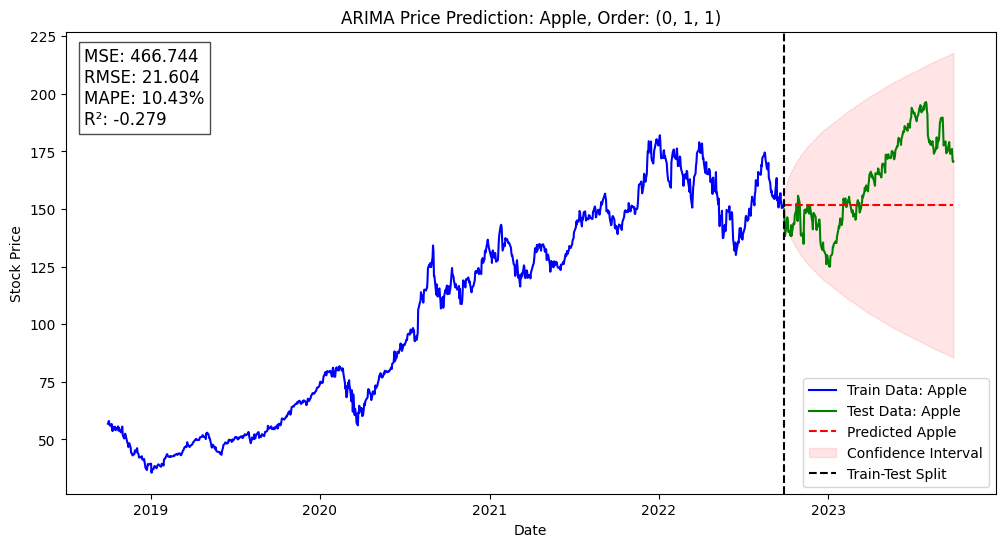

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4991.234, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4992.280, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4992.324, Time=1.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4989.257, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4992.369, Time=0.76 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.813 seconds


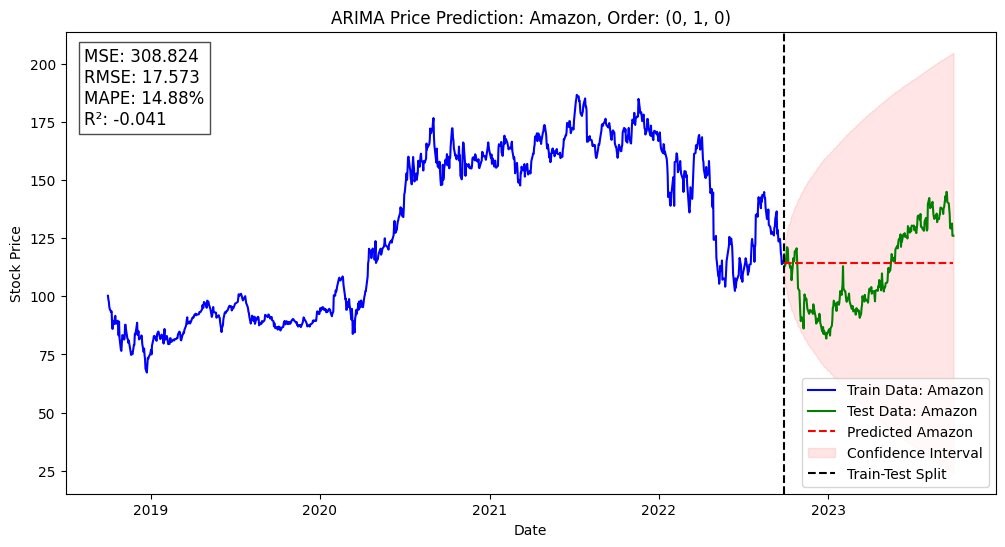

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=658.952, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=660.204, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=660.350, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=657.414, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=653.874, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=648.637, Time=1.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=647.345, Time=0.99 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=649.193, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=650.095, Time=1.22 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=645.681, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=658.639, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=647.520, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=646.931, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=652.158, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=648.3

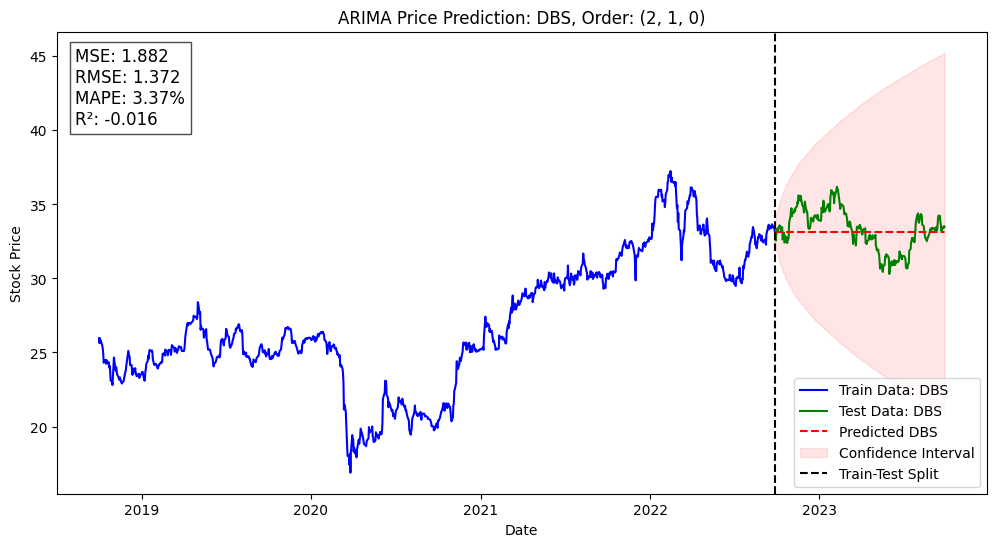

In [14]:
for cols in df.columns:
    ARIMA_forecast(df, cols, plot_ts=True, summary=False, output=False, tuning='auto_arima')

# Stock Prediction with VAR

## VAR function library

In [138]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

def time_series_var_plot(df, stock, y_hat, conf_interval):
    train_df, test_df = time_series_split(df)
    y_test = test_df[stock]
    plt.figure(figsize=(12, 6))

    # Actual price
    plt.plot(train_df.index, train_df[stock], label=f"Train Data: {stock}", color="blue")
    plt.plot(test_df.index, test_df[stock], label=f"Test Data: {stock}", color="green")

    # Predicted price
    plt.plot(test_df.index, y_hat, label=f"Predicted {stock}", color="red", linestyle="dashed")
    plt.fill_between(test_df.index, conf_interval.iloc[:, 0], conf_interval.iloc[:, 1],
                     color="red", alpha=0.1, label="Confidence Interval")

    # Train-Test Split marker
    plt.axvline(x=test_df.index[0], color="black", linestyle="dashed", label="Train-Test Split")

    # Add performance metrics
    metrics = performance_metrics(y_test, y_hat)
    metrics_text = f"MSE: {metrics['MSE']:.3f}\nRMSE: {metrics['RMSE']:.3f}\nMAPE: {metrics['MAPE']:.2%}\nR²: {metrics['R²']:.3f}"
    plt.text(
        0.02, 0.8, metrics_text, transform=plt.gca().transAxes, fontsize=12,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="black")
    )
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title(f"VAR Price Prediction: {stock}")
    plt.legend(loc='lower right')
    plt.show()


def performance_metrics(y_test, y_hat):
    """
        Computes and returns model performance metrics.
    """
    return {
        "MSE": mean_squared_error(y_test, y_hat),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_hat)),
        "MAPE": mean_absolute_percentage_error(y_test, y_hat),
        "R²": r2_score(y_test, y_hat)
    }


def time_series_split(df, split_ratio=None):

    if split_ratio is None:
        split_ratio = 0.8
    split_idx = int(len(df) * split_ratio)

    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]

    return train_df, test_df


def check_stationarity(data, alpha=0.05):
    result = adfuller(data.dropna())
    return result[1] < alpha # returns true if stationary


def make_stationary(df):
    """Applies differencing iteratively until all columns are stationary."""
    df_diff = df.copy()
    diff_count = 0

    while True:
        non_stationary = [col for col in df_diff.columns if not check_stationarity(df_diff[col])]

        if not non_stationary:
            break  # Exit when all columns are stationary

        df_diff[non_stationary] = df_diff[non_stationary].diff().dropna()
        diff_count += 1

        if diff_count > 10:  # Prevent infinite loop
            print("Warning: Data did not become stationary after 10 iterations.")
            break

    return df_diff


def VAR_hyperparameter_tune(df, max_lag=10):
    best_aic = float("inf")
    best_lag = None

    for p in range(1, max_lag + 1):
        try:
            model = VAR(df.dropna())
            result = model.fit(p)
            if result.aic < best_aic:
                best_aic = result.aic
                best_lag = p
        except:
            continue

    return best_lag


def VAR_forecast(df, split_ts=None):
    # Ensure all columns are stationary
    df_diff = df.copy().diff().dropna()

    # Train test split
    if split_ts:
        train_df, test_df = time_series_split(df_diff)
    else:
        train_df = df_diff

    # Train the VAR Model
    var_model = VAR(train_df)
    var_fit = var_model.fit()  # Fit VAR model with optimal lags

    #  Forecast Future Values
    steps = len(test_df)
    last_train_values = train_df.values[-var_fit.k_ar:]  # Take the last "lag" observations
    forecast_values = var_fit.forecast(last_train_values, steps=steps)

    # Convert Forecast to DataFrame
    forecast_df = pd.DataFrame(forecast_values, index=test_df.index, columns=df.columns)

    # Inverse Differencing to Restore Original Scale
    # Use last known values before differencing
    last_values = df.iloc[len(train_df)]  # Correct last known row before differencing
    forecast_cumsum = forecast_df.cumsum() + last_values # restore original scale

    # Confidence Interval Calculation (Using Residual Variance)
    residual_variance = var_fit.resid.var()
    conf_interval_lower = forecast_cumsum - 1.96 * np.sqrt(residual_variance)
    conf_interval_upper = forecast_cumsum + 1.96 * np.sqrt(residual_variance)
    conf_interval = pd.concat([conf_interval_lower, conf_interval_upper], axis=1)

    # Prepare DataFrame for Output
    temp_df = df.copy()

    # Generate predicted column names
    pred_col = [f"{col}_pred" for col in df.columns]
    temp_df[pred_col] = np.nan  # Initialize predicted columns with NaN

    # Assign predictions to correct index
    test_pred = forecast_cumsum.values
    # conf_interval = var_fit.forecast_interval(last_train_values, steps=steps)
    temp_df.loc[test_df.index, pred_col] = test_pred

    return temp_df, test_pred, conf_interval


## VAR prediction

In [139]:
var_df, yhat, confi_interval = VAR_forecast(df, split_ts=True)

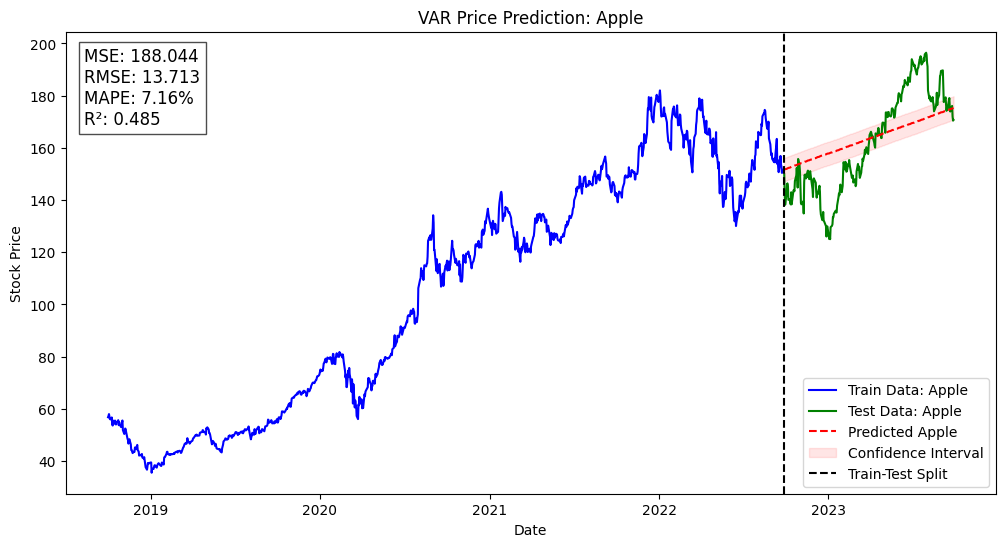

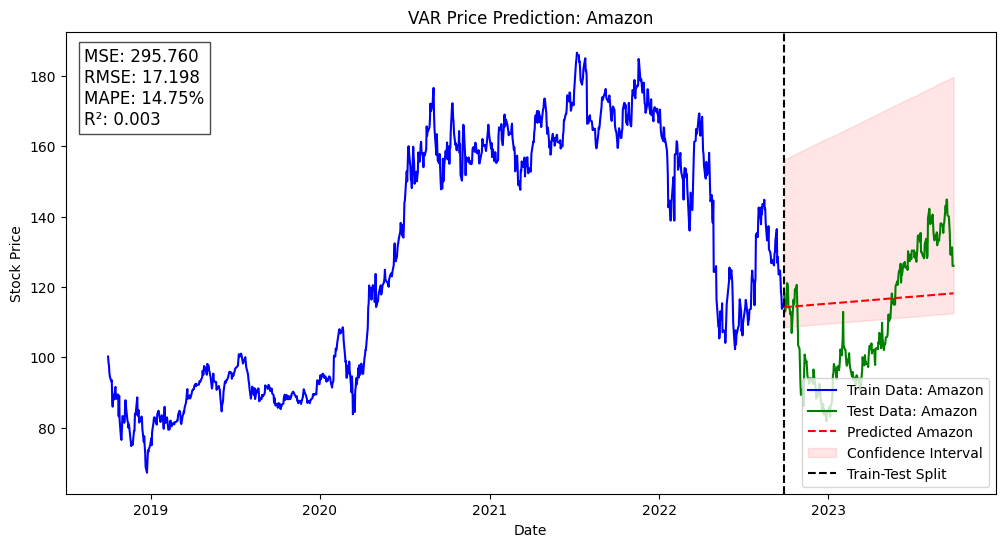

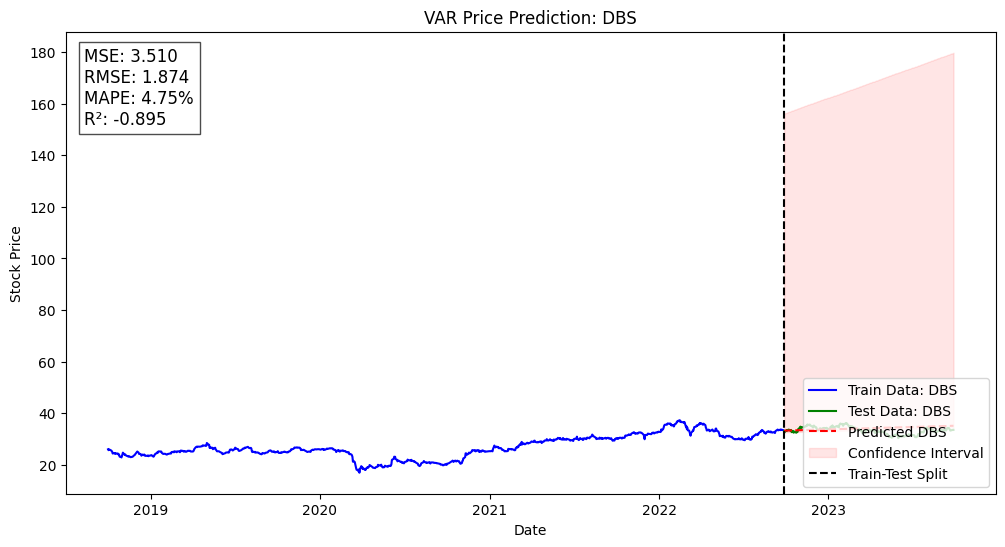

In [142]:
for i,col in enumerate(df.columns):
    time_series_var_plot(var_df, col, yhat[:, i], confi_interval.iloc[:, [i, len(df.columns)]])
